# Allocation-Interval-Tracker Compression Results

This project is a tool to perform various tests on allocations at timed intervals throughout program runtime.

1. [Imports](#1-imports)
2. [Read Data](#2-read-data)
3. [Process Results](#3-process-results)
    1. [Resident Compressibility](#31-resident-compressibility)
    2. [Most Compressible Sites](#32-most-compressible-sites)
    3. [Compare Compressibility of Clean vs. Dirty Data](#33-compare-compressibility-of-clean-vs-dirty-data)
    4. [Most Compressible Clean Sites](#34-most-compressible-clean-sites)
    5. [Identify Compressible, But Hot Data](#35-identify-compressible-but-hot-data-not-desirable)

## 1. Imports

Import the libraries to process the data

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 2. Read Data

Read in the data for each test result.

In [50]:
# The data is stored in a 5XX.csv for the serial tests, and 6XX.csv for the parallel tests
# The data files are in the `/data` folder


# A structure for storing the data
data = {}

for i in range(500, 600):
    if os.path.isfile("data/" + str(i) + ".csv"):
        data[i] = pd.read_csv("data/" + str(i) + ".csv")
        print("Loaded data for test " + str(i))

Loaded data for test 505
Loaded data for test 508
Loaded data for test 511
Loaded data for test 519


## 3. Process Results

Go through the data and process some results.

## 3.1 Resident Compressibility

This just shows the compressibility of **all** the data in the allocation site's resident pages (clean or dirty).

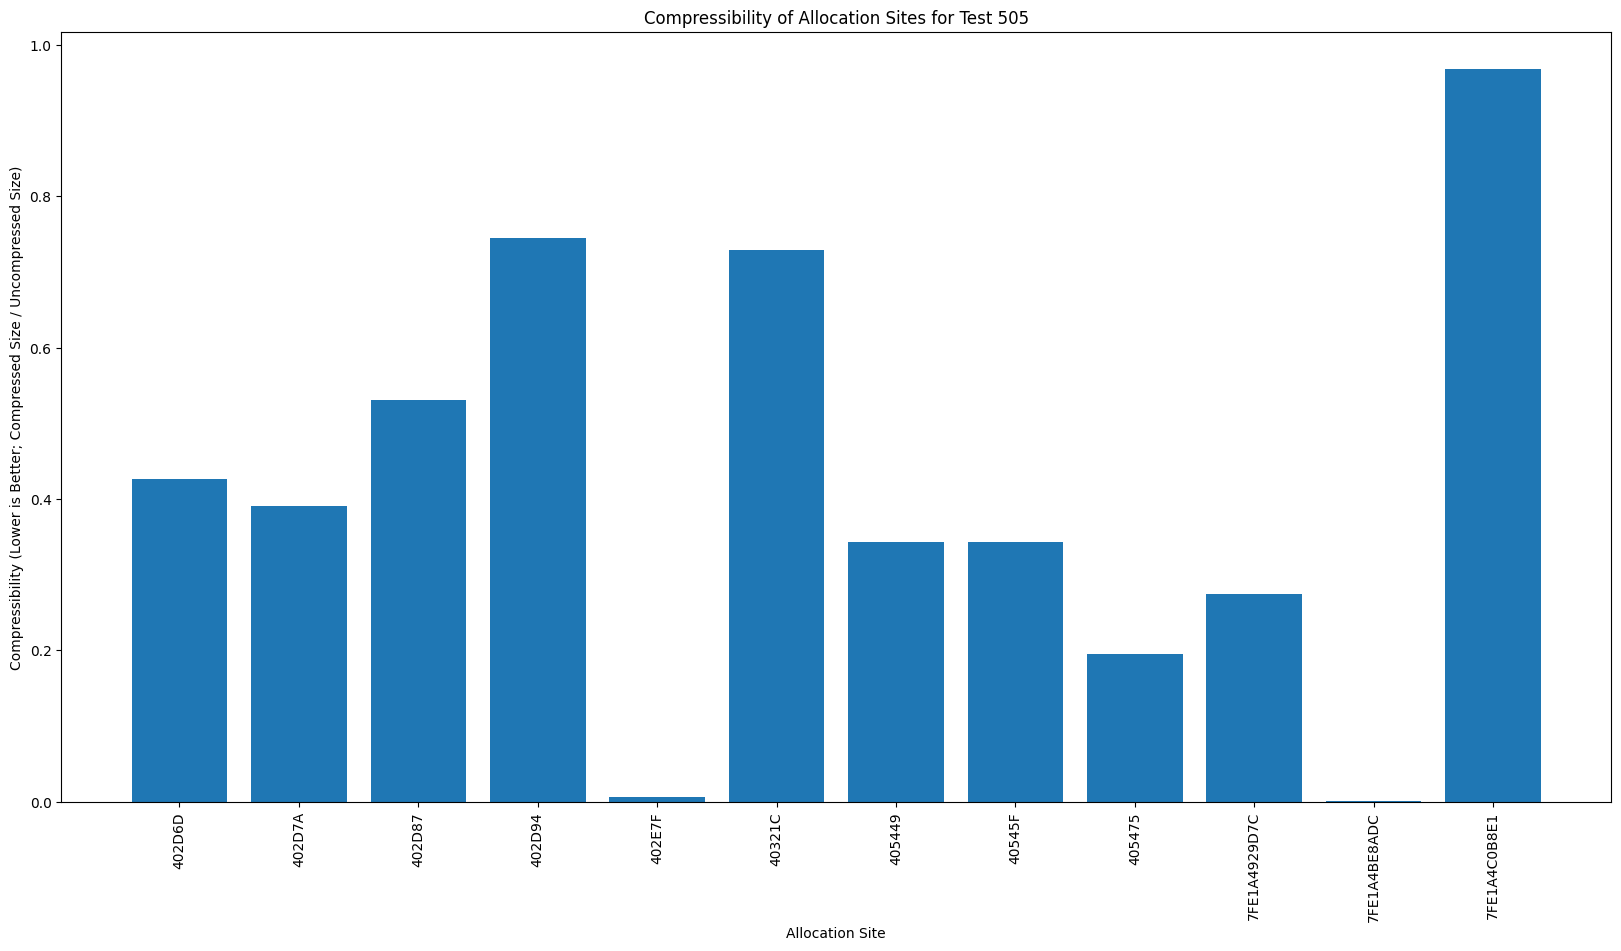

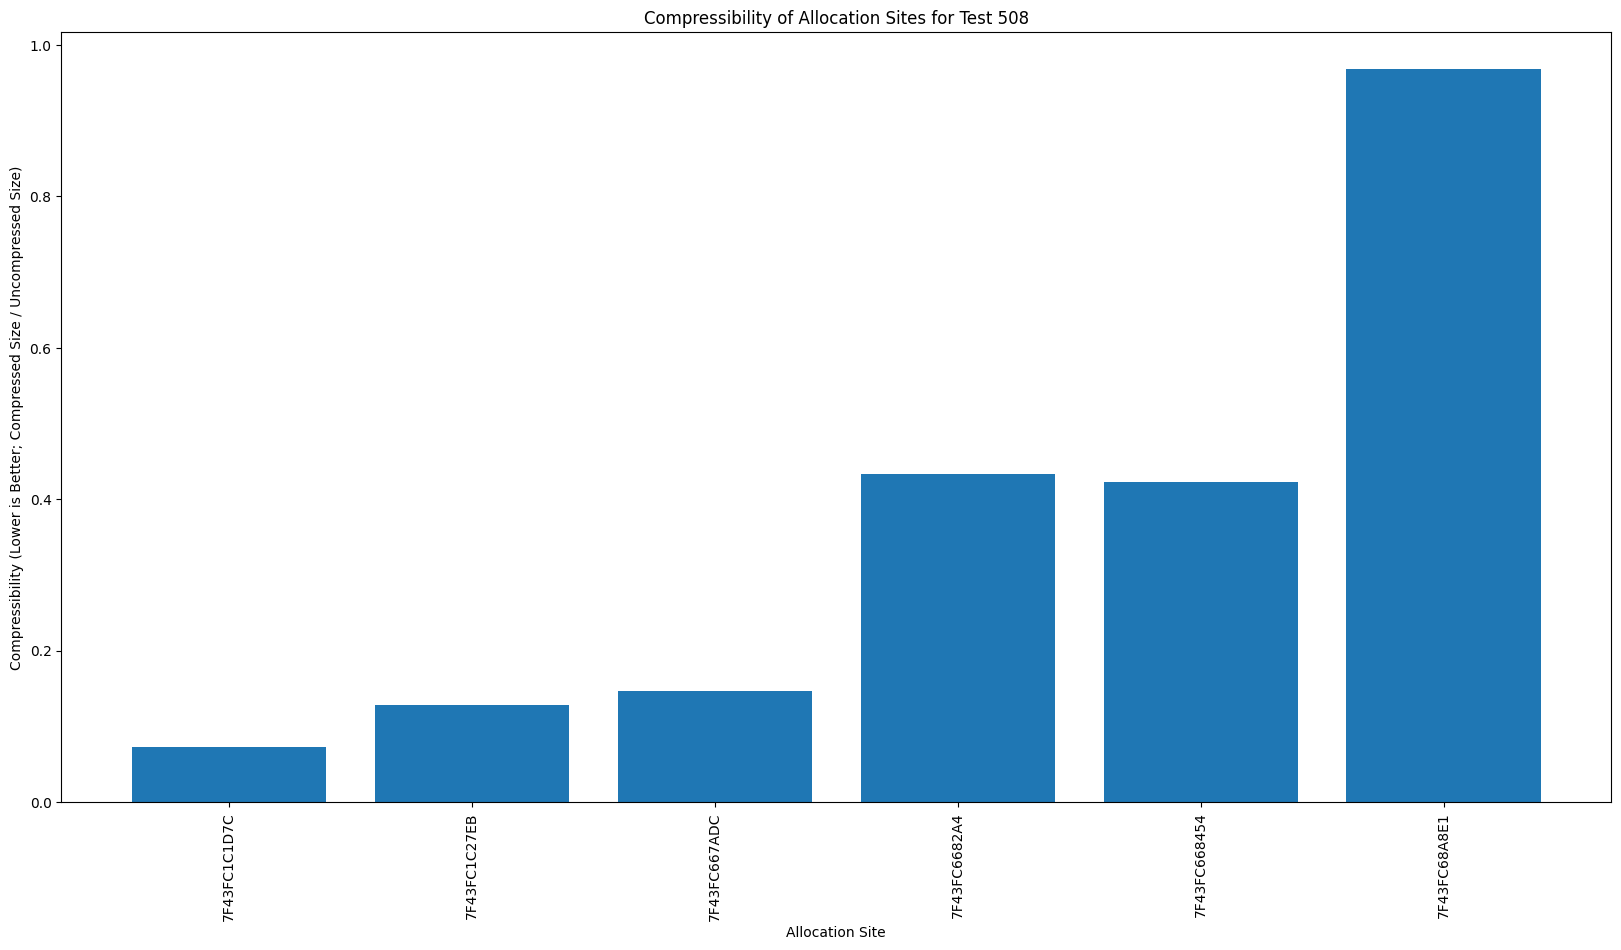

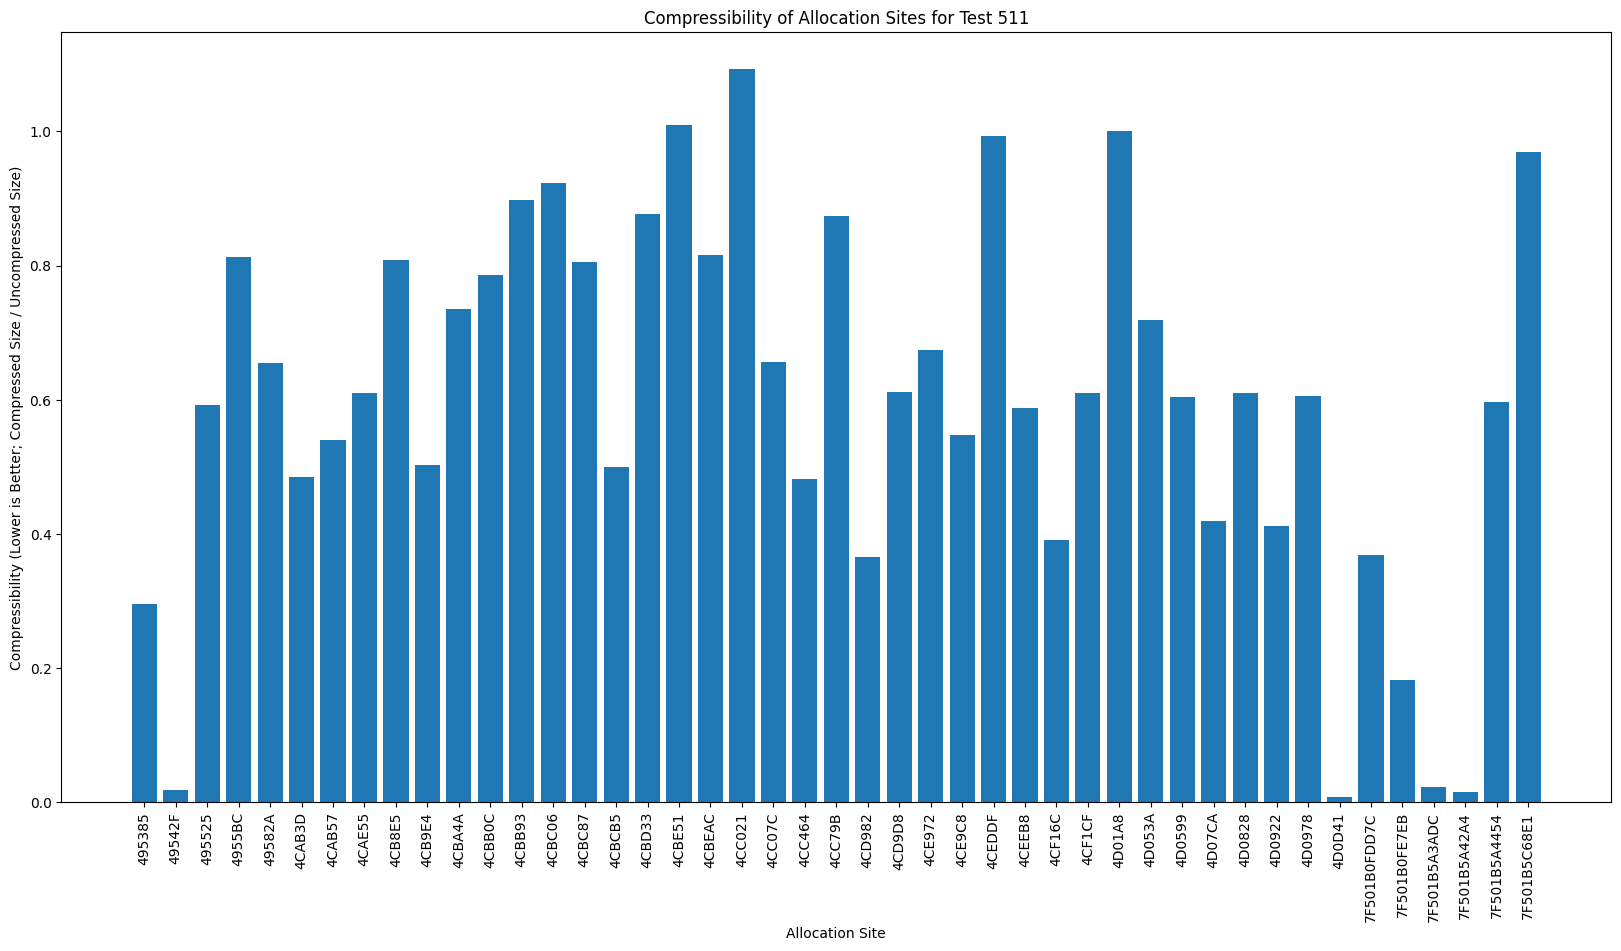

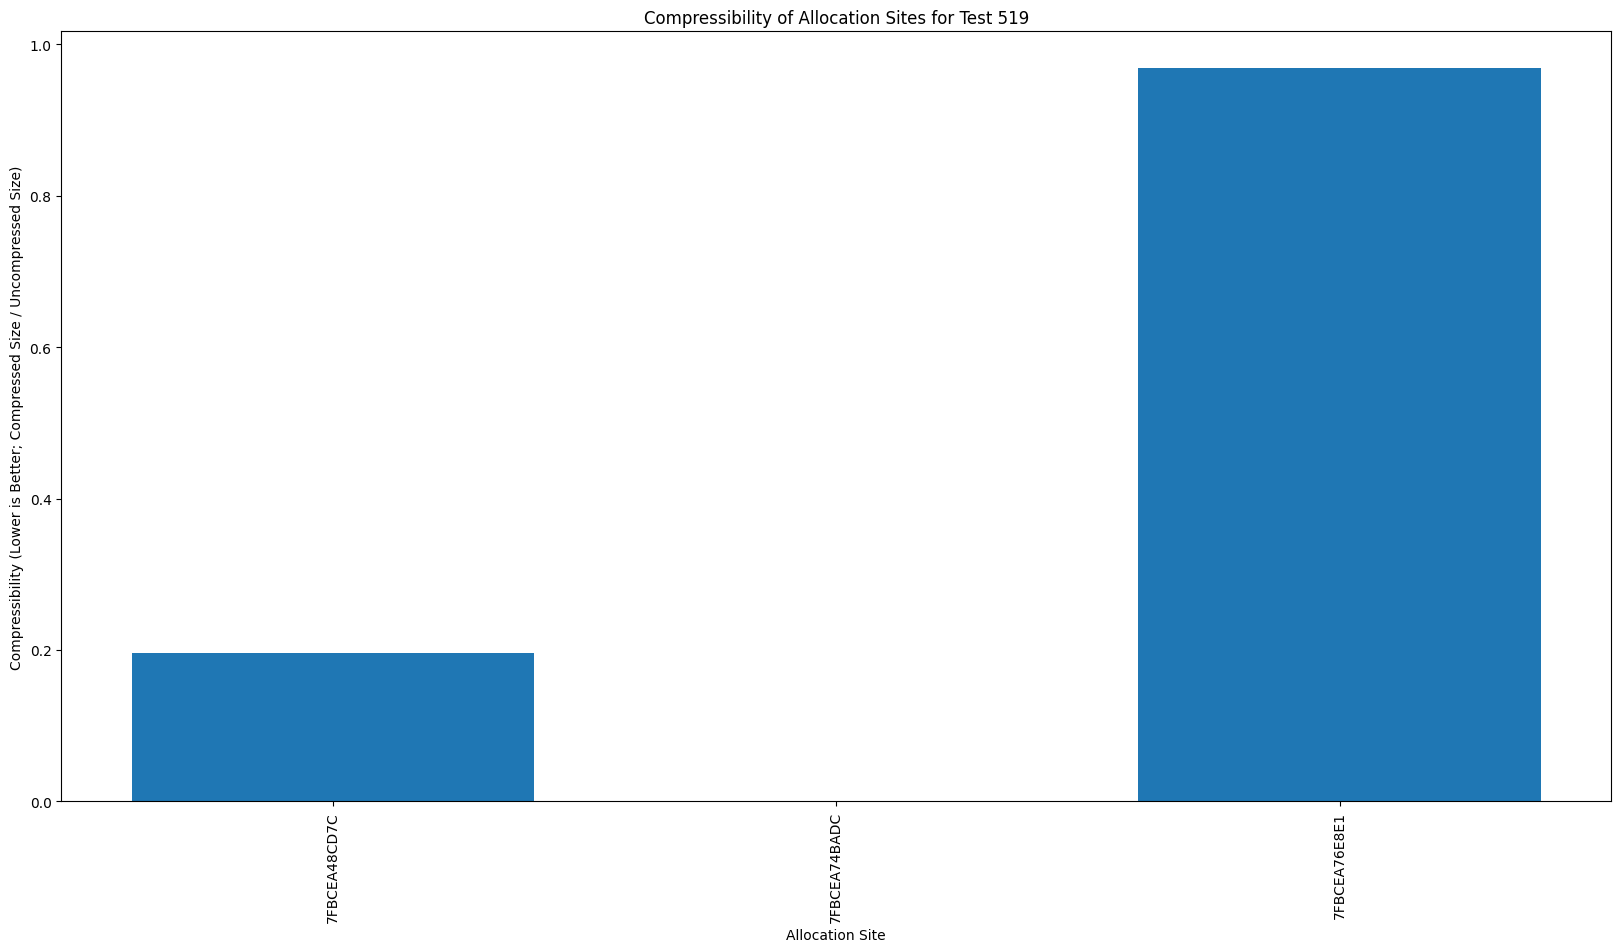

In [51]:
# First, lets graph the compressibility of all the "Allocation Site" values.
# The goal is to show which allocation sites are more compressible than others.

# Get the tests from the data
tests = data.keys()
for test in tests:
    # Get the data for the test
    test_data = data[test]
    # Get the allocation sites
    allocation_sites = test_data["Allocation Site"].unique()
    # Get the compressed and uncompressed sizes for the allocation sites
    compressed_sizes = test_data.groupby("Allocation Site")["Total Compressed Resident Size"]
    uncompressed_sizes = test_data.groupby("Allocation Site")["Total Uncompressed Resident Size"]
    
    # Get the compressibility of each allocation site
    compressibility = compressed_sizes.sum() / uncompressed_sizes.sum()

    # Plot the compressibility
    plt.figure(figsize=(20,10))
    plt.title("Compressibility of Allocation Sites for Test " + str(test))
    plt.xlabel("Allocation Site")
    plt.ylabel("Compressibility (Lower is Better; Compressed Size / Uncompressed Size)")
    plt.xticks(rotation=90)
    plt.bar(compressibility.index, compressibility.values)
    plt.show()


## 3.2 Most Compressible Sites

Find the sites with the most compressible data.

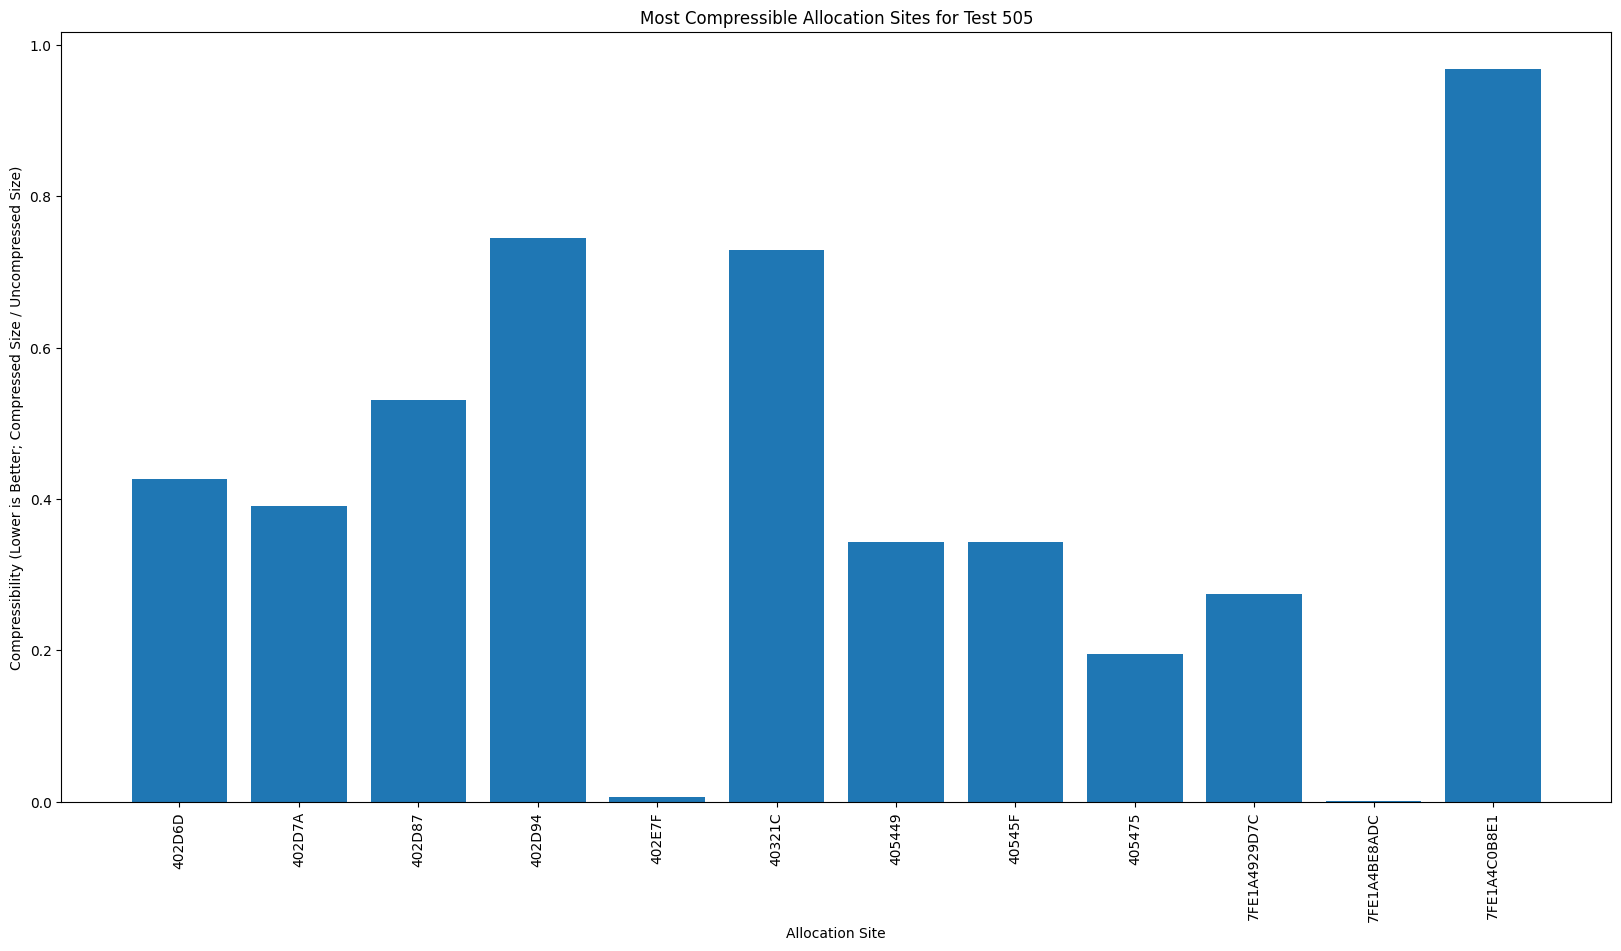

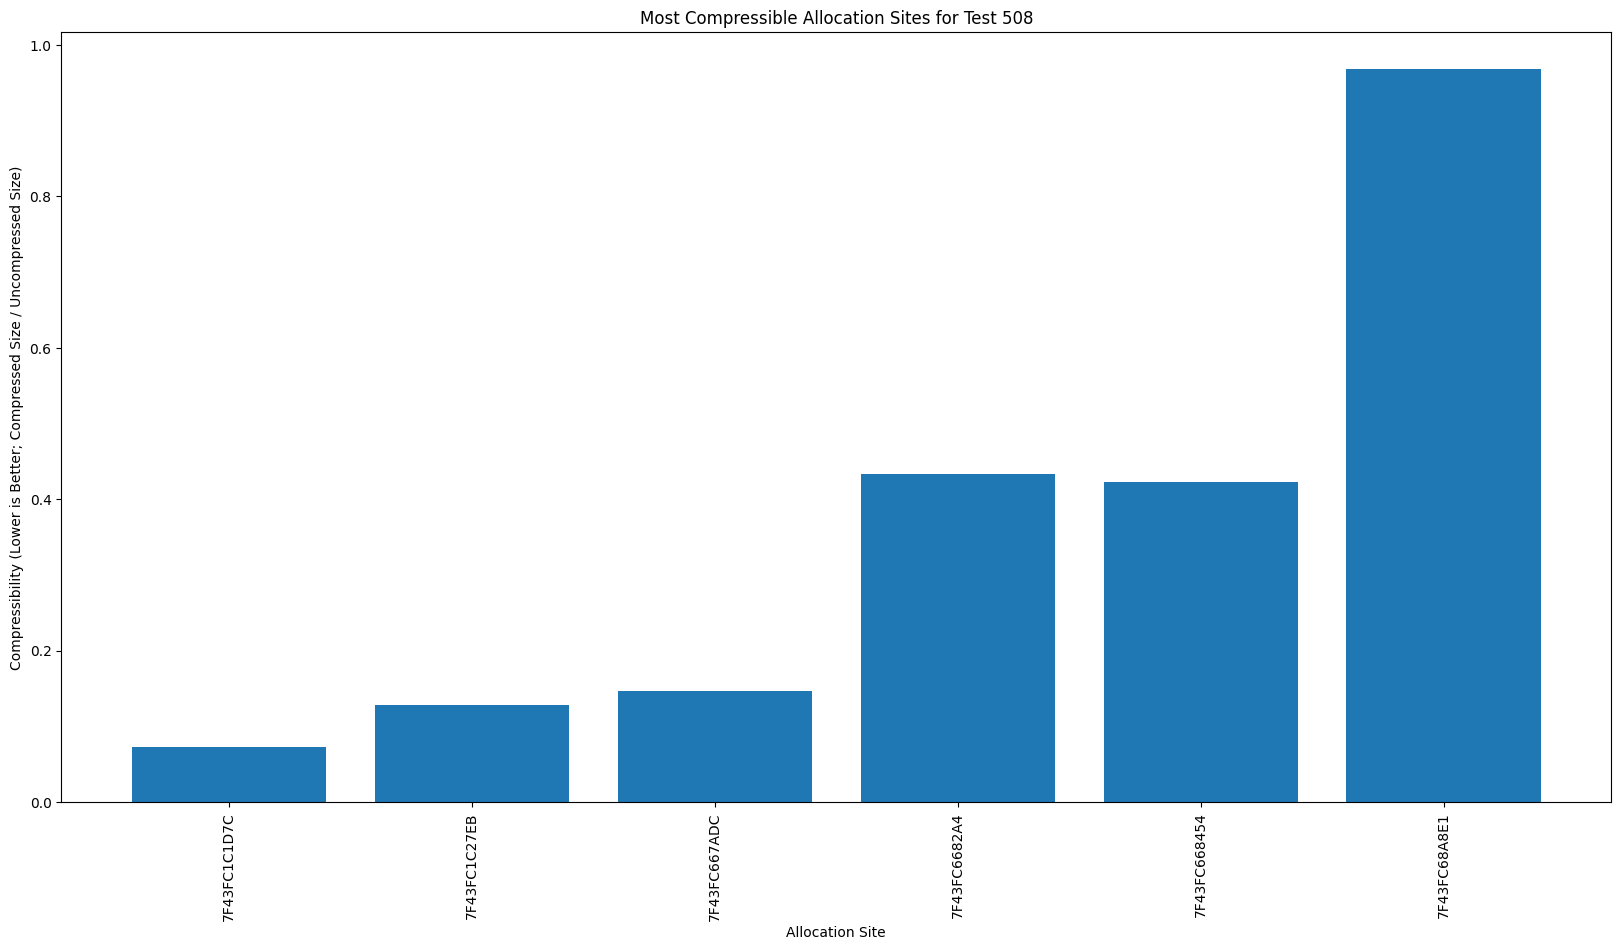

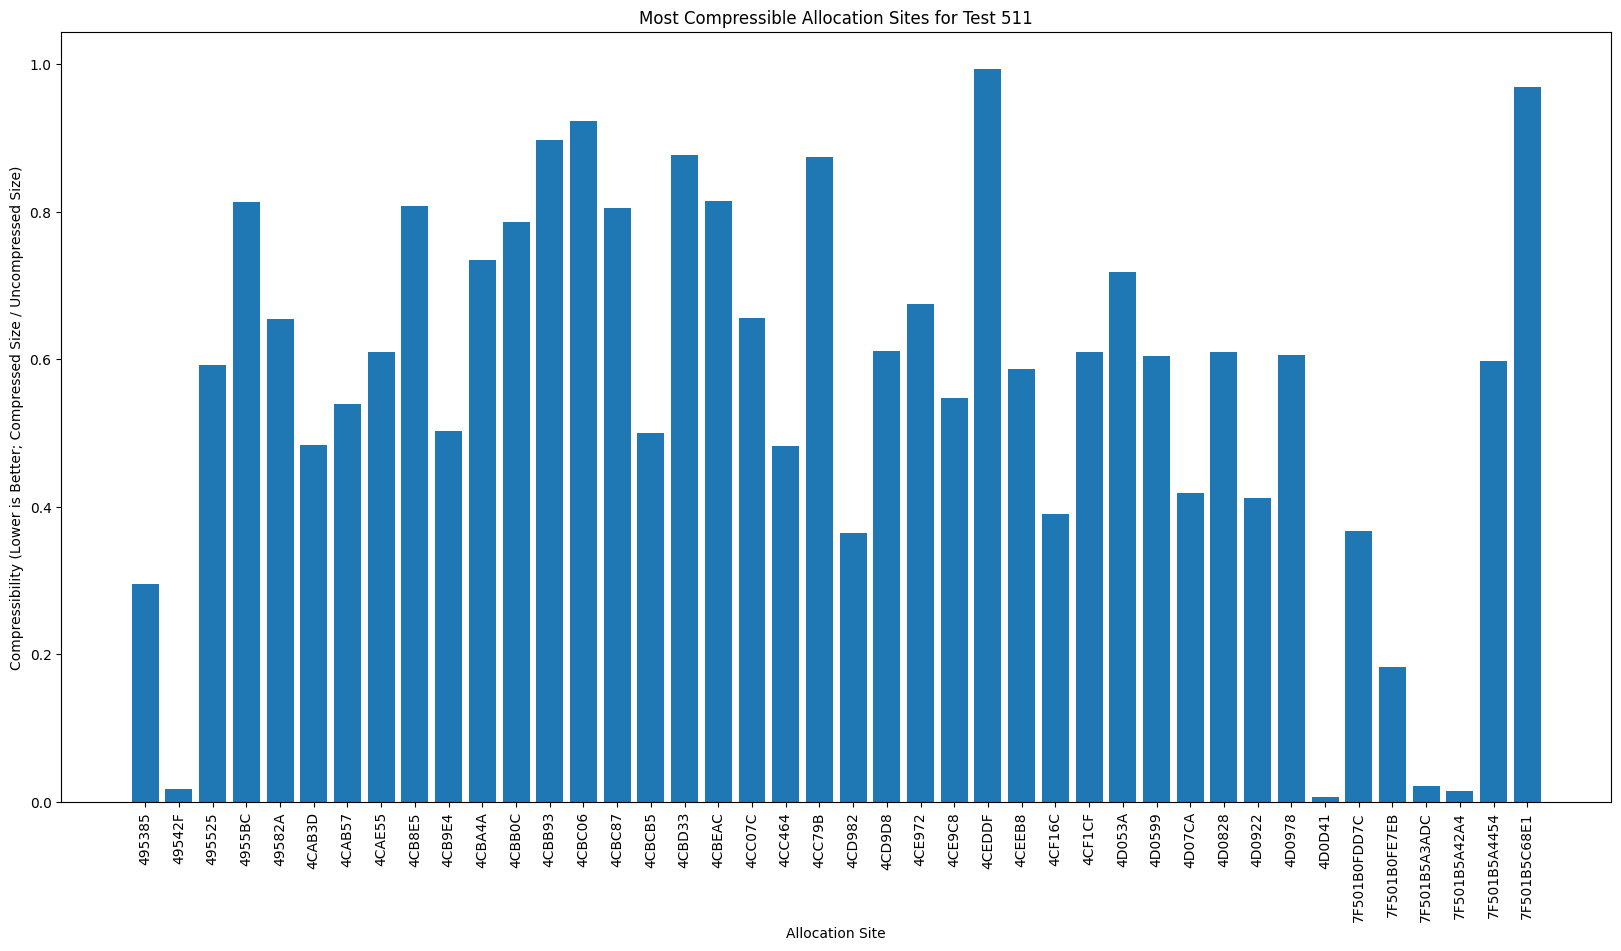

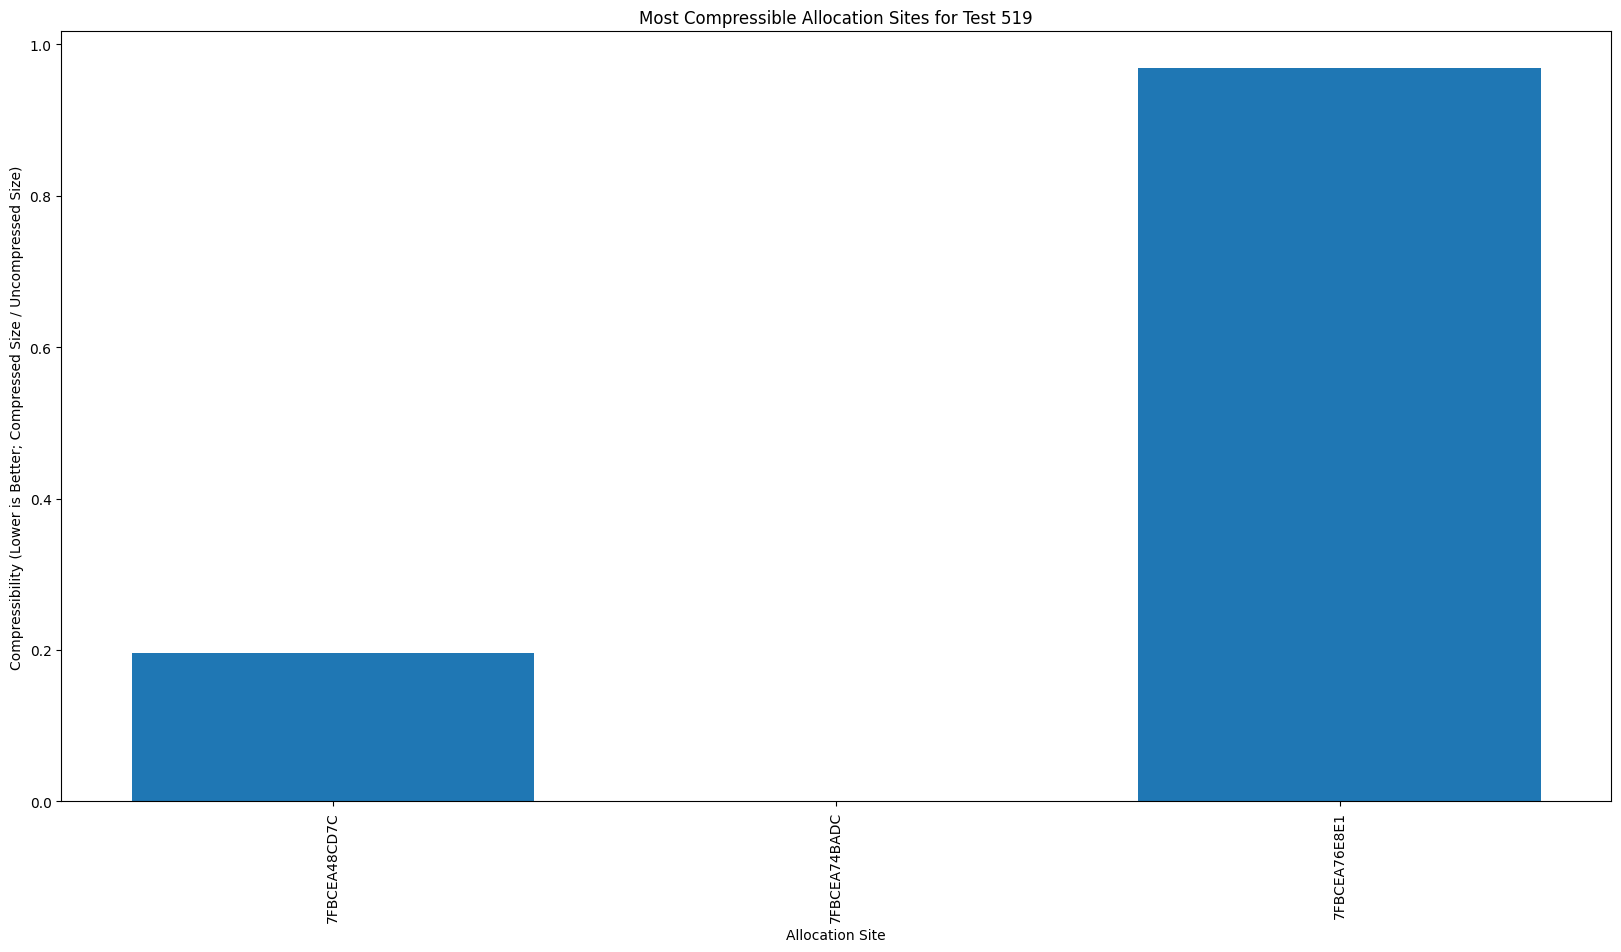

In [52]:

# Get the tests from the data
tests = data.keys()
for test in tests:
    # Get the data for the test
    test_data = data[test]
    # Get the allocation sites
    allocation_sites = test_data["Allocation Site"].unique()
    # Get the compressed and uncompressed sizes for the allocation sites
    compressed_sizes = test_data.groupby("Allocation Site")["Total Compressed Resident Size"]
    uncompressed_sizes = test_data.groupby("Allocation Site")["Total Uncompressed Resident Size"]
    
    # Get the compressibility of each allocation site
    compressibility = compressed_sizes.sum() / uncompressed_sizes.sum()

    # The same plot, but for all the compressibility values less than one (i.e. the compressible ones)
    plt.figure(figsize=(20,10))
    plt.title("Most Compressible Allocation Sites for Test " + str(test))
    plt.xlabel("Allocation Site")
    plt.ylabel("Compressibility (Lower is Better; Compressed Size / Uncompressed Size)")
    plt.xticks(rotation=90)
    plt.bar(compressibility[compressibility < 1].index, compressibility[compressibility < 1].values)
    plt.show()


## 3.3 Compare Compressibility of Clean vs. Dirty data

This determines the compressibility of pages that were dirty and the compressibility of pages that were "clean" (dirty bit not set).

<Figure size 640x480 with 0 Axes>

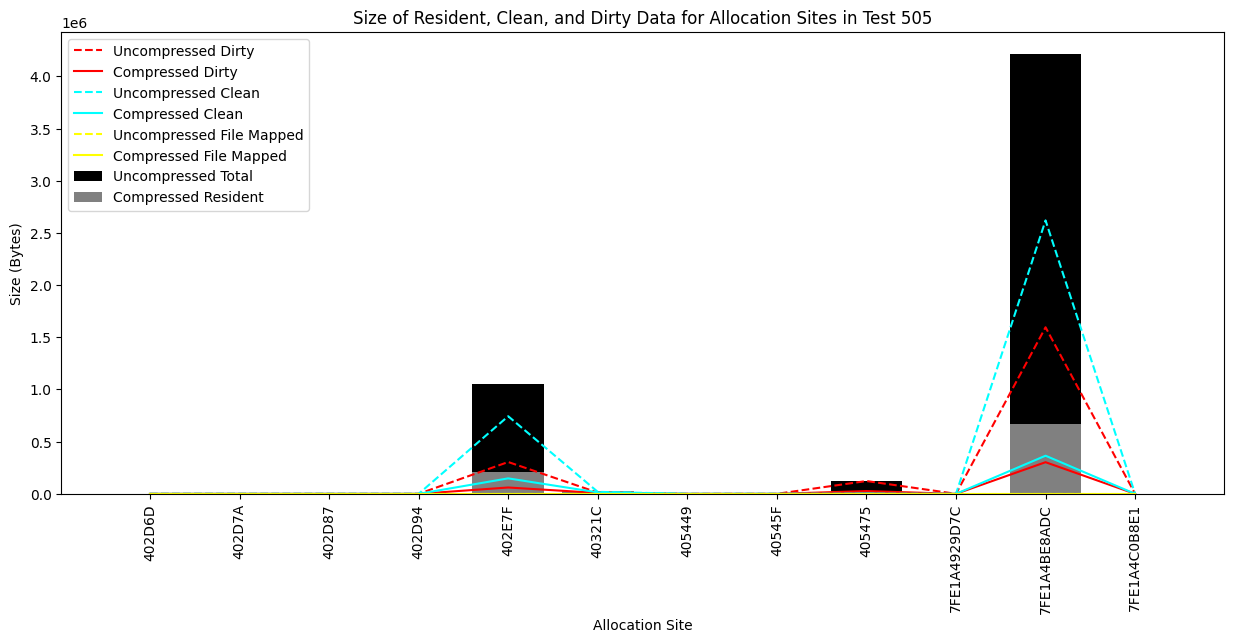

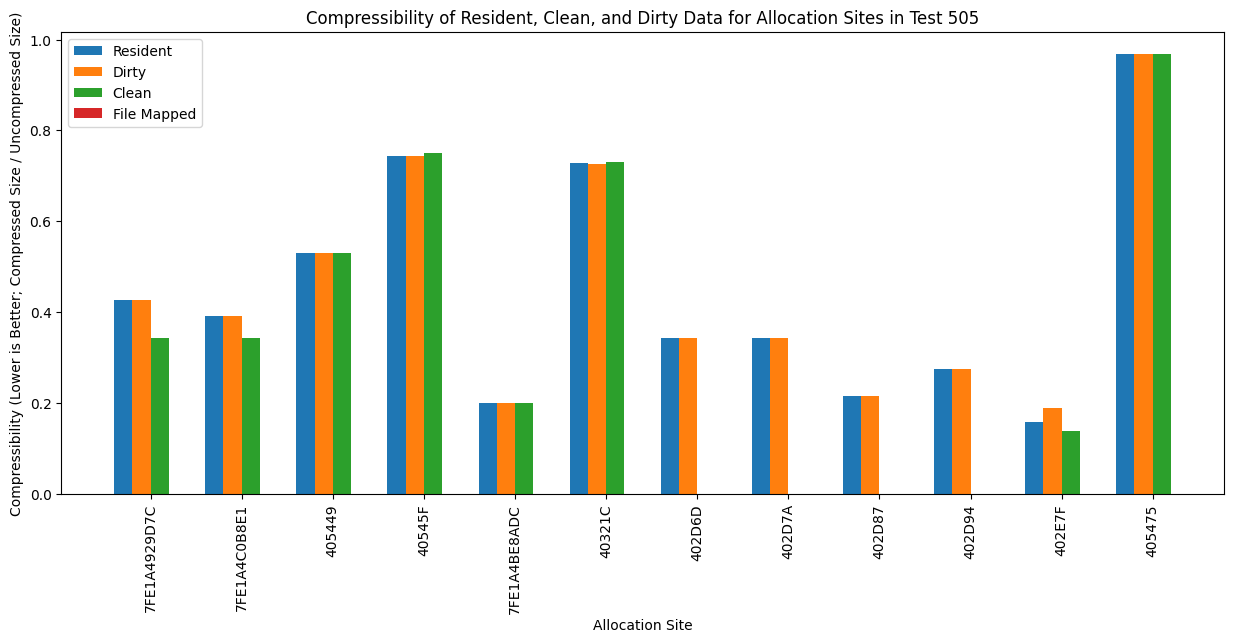

<Figure size 640x480 with 0 Axes>

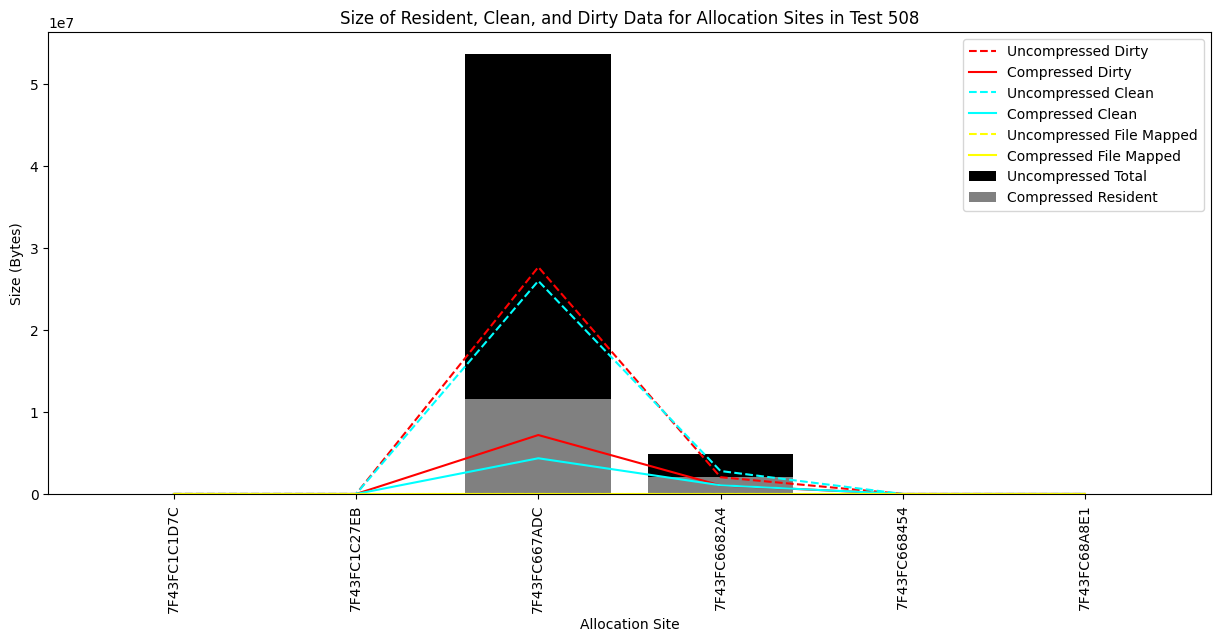

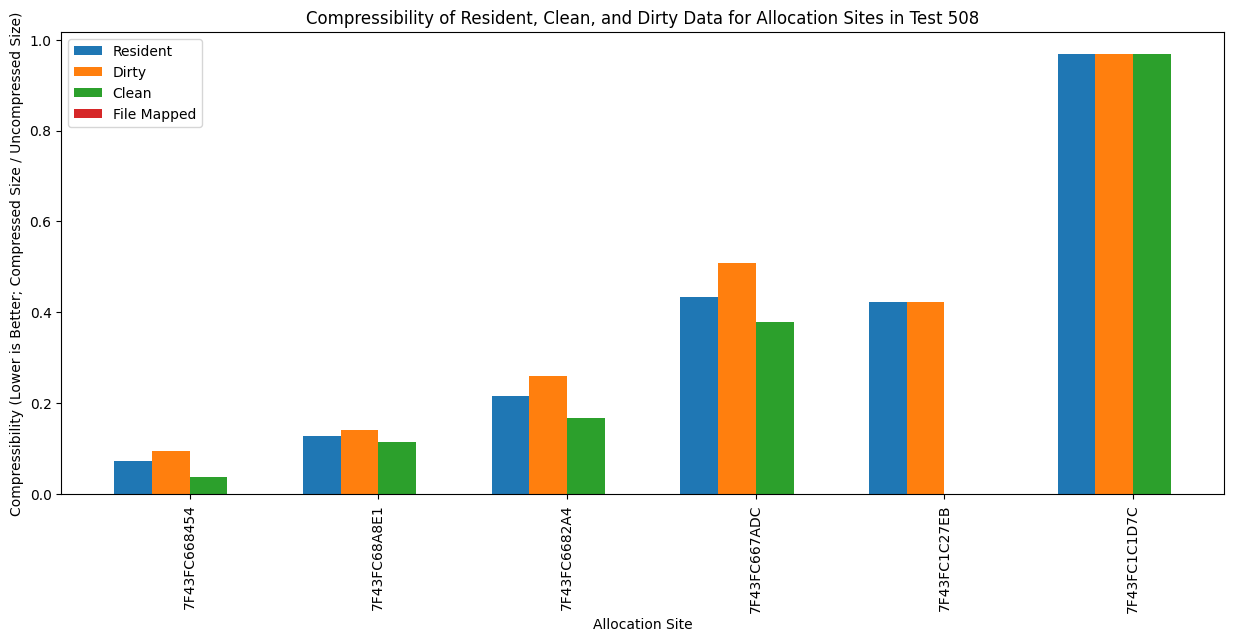

<Figure size 640x480 with 0 Axes>

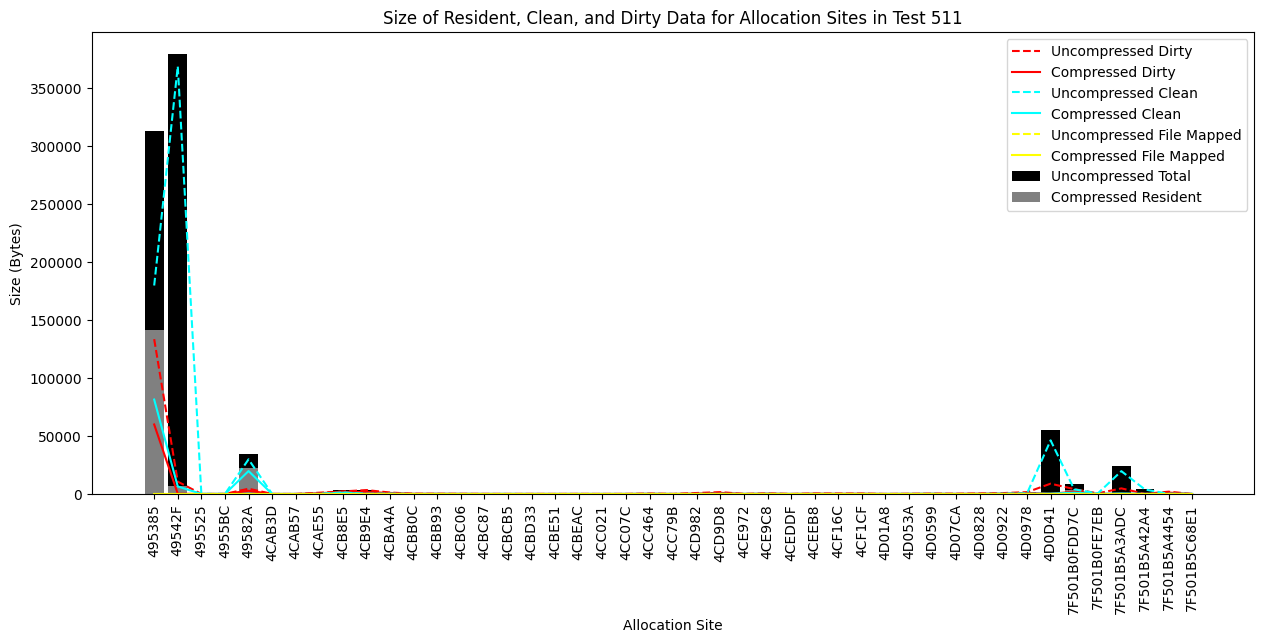

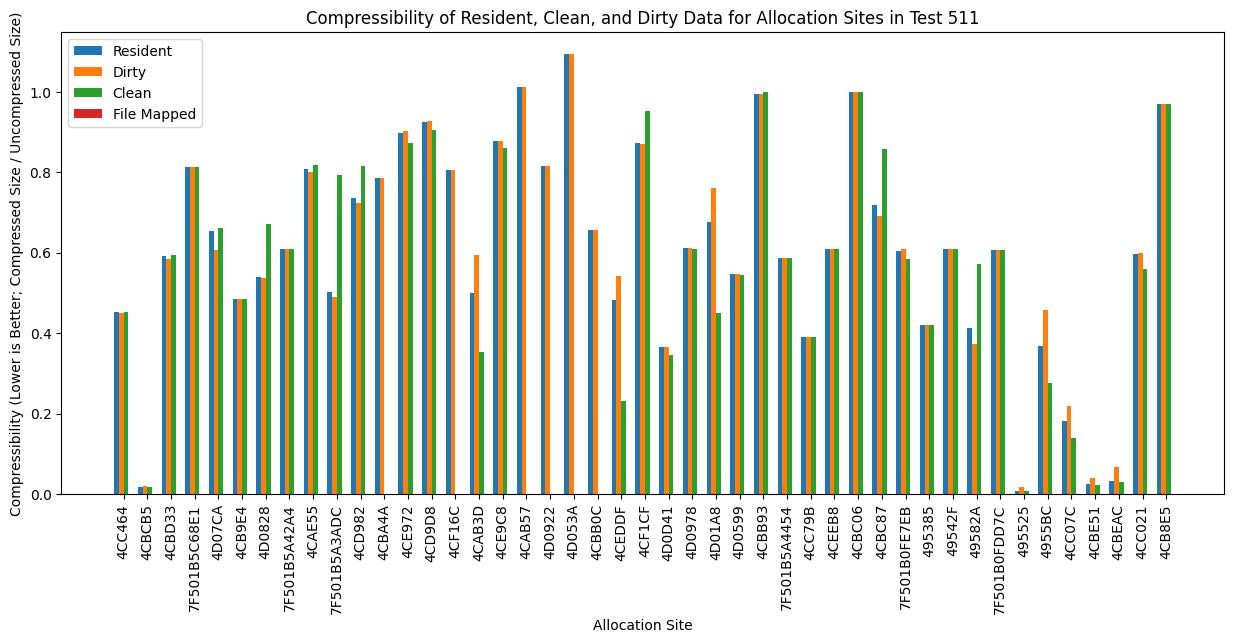

<Figure size 640x480 with 0 Axes>

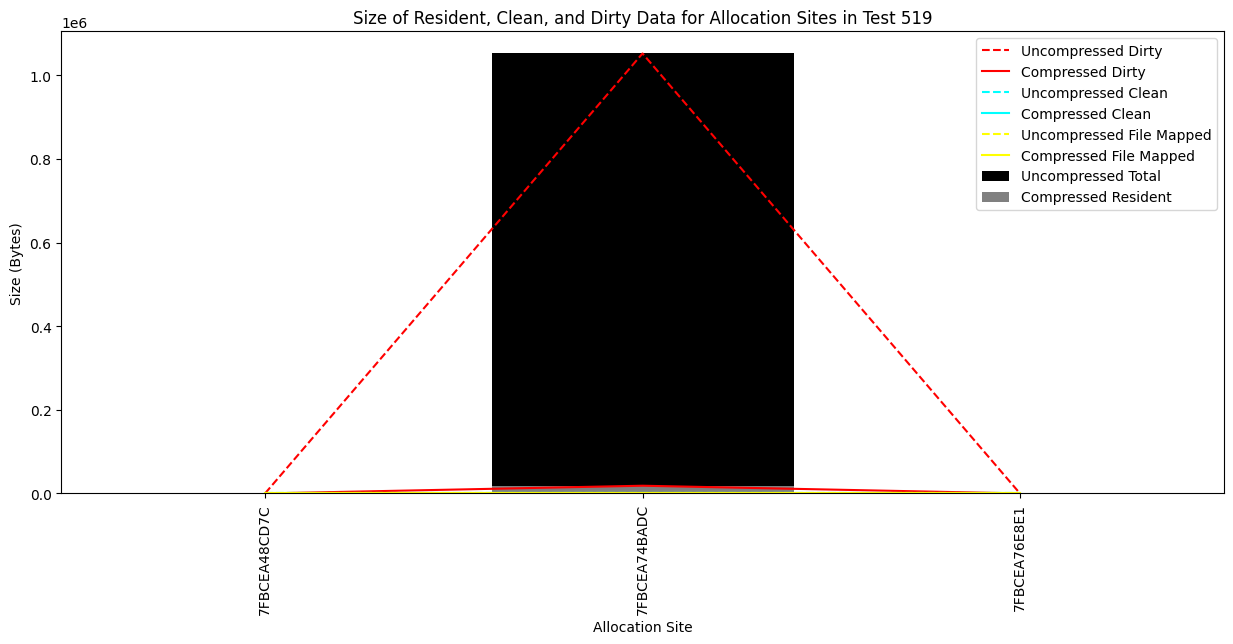

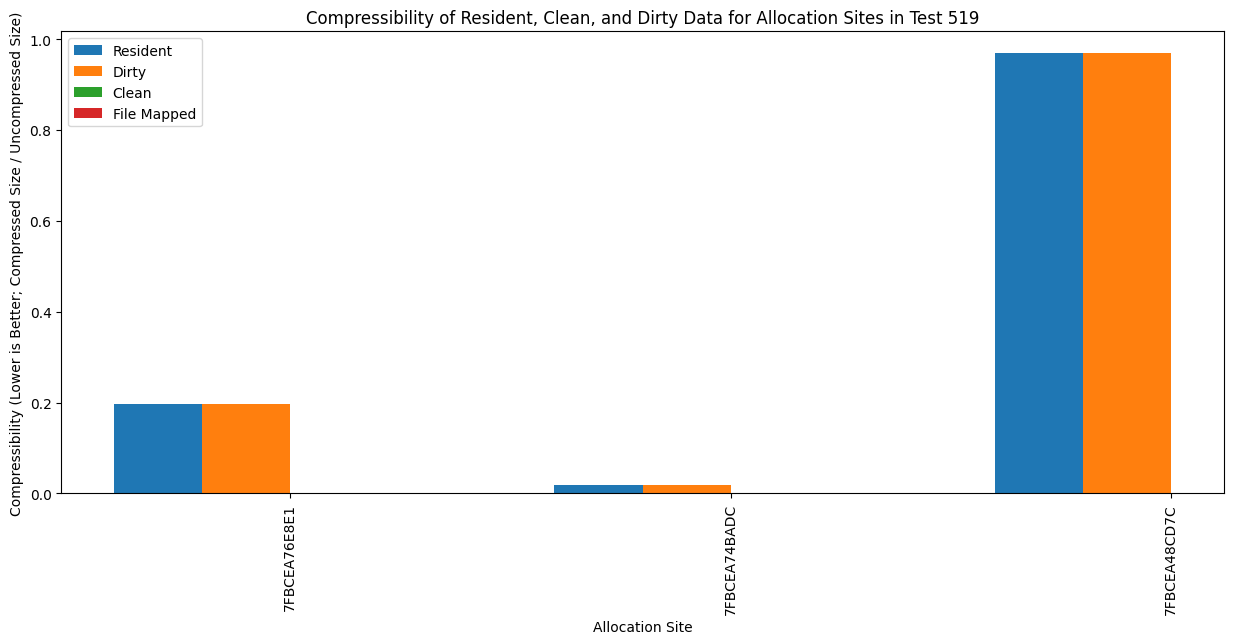

In [53]:

    
# Get the tests from the data
tests = data.keys()
for test in tests:
    # Get the data for the test
    test_data = data[test]
    # Get the allocation sites
    allocation_sites = test_data["Allocation Site"].unique()

    compressed_clean_sizes = test_data.groupby("Allocation Site")["Total Compressed Clean Size"].mean()
    uncompressed_clean_sizes = test_data.groupby("Allocation Site")["Total Uncompressed Clean Size"].mean()

    compressed_dirty_sizes = test_data.groupby("Allocation Site")["Total Compressed Dirty Size"].mean()
    uncompressed_dirty_sizes = test_data.groupby("Allocation Site")["Total Uncompressed Dirty Size"].mean()
    
    # Get the compressibility of each allocation site
    compressed_file_mapped_sizes = test_data.groupby("Allocation Site")["Total Compressed File Mapped Size"].mean()
    uncompressed_file_mapped_sizes = test_data.groupby("Allocation Site")["Total Uncompressed File Mapped Size"].mean()

    #### NOTE:
    # I do NOT use the `Total Uncompressed Resident Size` column here!!!
    # This is because these are the raw sizes (the sizes passed to `malloc`) of the allocations made by the program
    # ***before being truncated to a 0x100000 byte buffer for compression!***
    # I plan to change this so the truncated size is much larger, or so that the
    # program does not truncate the allocations at all by doing chunks of 0x100000 bytes at a time. This will
    # allow us to see the true size of the allocations, and not just the truncated size.
    # 
    # If I used the `Total Uncompressed Resident Size` columns, then the
    # clean and dirty sizes will look artificially small because they are truncated to 0x100000 bytes, while
    # the resident size is not truncated.
    compressed_resident_sizes = test_data.groupby("Allocation Site")["Total Compressed Resident Size"].mean() # this is okay because it is also truncated
    # uncompressed_resident_sizes = test_data.groupby("Allocation Site")["Total Uncompressed Resident Size"].mean() # this is NOT okay (for now) because it is not truncated
    uncompressed_resident_sizes = (uncompressed_clean_sizes + uncompressed_dirty_sizes)

    # Get the compressibility of each allocation site
    compressibility = compressed_resident_sizes.sum() / uncompressed_resident_sizes.sum()

    # Set the bar width based on the number of allocation sites
    bar_width = (len(test_data["Allocation Site"].unique()) + 1) / 10


    plt.figure()
    plt.figure(figsize=(15,6))
    plt.title("Size of Resident, Clean, and Dirty Data for Allocation Sites in Test " + str(test))
    plt.xlabel("Allocation Site")
    plt.ylabel("Size (Bytes)")
    # Put the allocation sites on the x-axis
    plt.xticks(rotation=90)

    plt.bar(uncompressed_resident_sizes.index, uncompressed_resident_sizes.values, label="Uncompressed Total", color="black")
    plt.bar(compressed_resident_sizes.index, compressed_resident_sizes.values, label="Compressed Resident", color="grey")
    plt.plot(uncompressed_dirty_sizes.index, uncompressed_dirty_sizes.values, label="Uncompressed Dirty", color="red", linestyle="dashed")
    plt.plot(compressed_dirty_sizes.index, compressed_dirty_sizes.values, label="Compressed Dirty", color="red", linestyle="solid")
    plt.plot(uncompressed_clean_sizes.index, uncompressed_clean_sizes.values, label="Uncompressed Clean", color="cyan", linestyle="dashed")
    plt.plot(compressed_clean_sizes.index, compressed_clean_sizes.values, label="Compressed Clean", color="cyan", linestyle="solid")
    plt.plot(uncompressed_file_mapped_sizes.index, uncompressed_file_mapped_sizes.values, label="Uncompressed File Mapped", color="yellow", linestyle="dashed")
    plt.plot(compressed_file_mapped_sizes.index, compressed_file_mapped_sizes.values, label="Compressed File Mapped", color="yellow", linestyle="solid")

    plt.legend()
    plt.show()


    # Show the compressibility of each category
    # Set the width and height of the figure
    plt.figure(figsize=(15,6))
    plt.title("Compressibility of Resident, Clean, and Dirty Data for Allocation Sites in Test " + str(test))
    plt.xlabel("Allocation Site")
    plt.ylabel("Compressibility (Lower is Better; Compressed Size / Uncompressed Size)")
    plt.xticks(rotation=90)

    dirty_compressibility = compressed_dirty_sizes / uncompressed_dirty_sizes
    clean_compressibility = compressed_clean_sizes / uncompressed_clean_sizes
    resident_compressibility = compressed_resident_sizes / uncompressed_resident_sizes
    file_mapped_compressibility = compressed_file_mapped_sizes / uncompressed_file_mapped_sizes
    columns = 5
    last = left_positions = np.arange(len(resident_compressibility)) * columns * bar_width
    last = resident_positions = last + bar_width
    last = dirty_positions = last + bar_width
    last = clean_positions = last + bar_width
    last = file_mapped_positions = last + bar_width
    last = right_positions = last + bar_width
    center_positions = (left_positions + right_positions) / 2

    plt.xticks(center_positions, test_data["Allocation Site"].unique())
    plt.bar(resident_positions, resident_compressibility, width=bar_width, label="Resident")
    plt.bar(dirty_positions, dirty_compressibility, width=bar_width, label="Dirty")
    plt.bar(clean_positions, clean_compressibility, width=bar_width, label="Clean")
    plt.bar(file_mapped_positions, file_mapped_compressibility, width=bar_width, label="File Mapped")

    plt.legend()

## 3.4 Most Compressible Clean Sites

Find the allocation sites with the most compressible clean data.

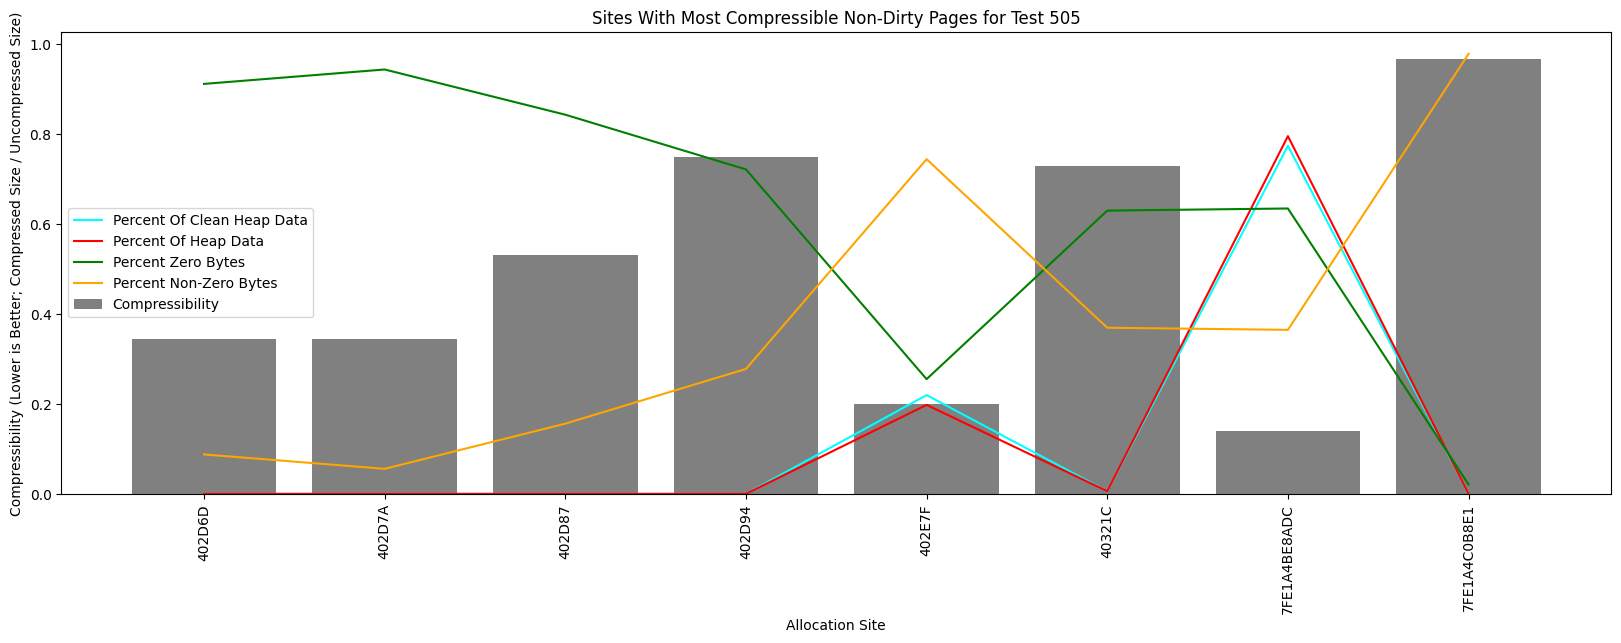

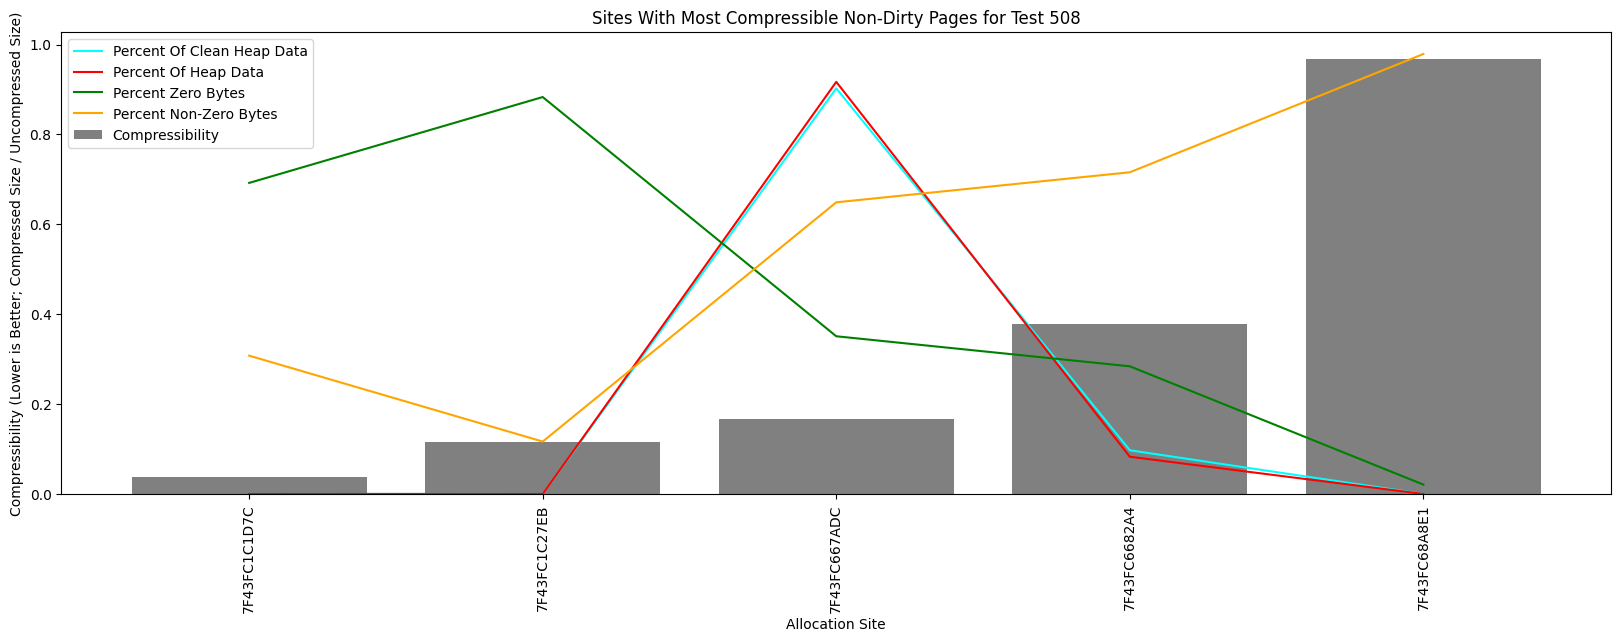

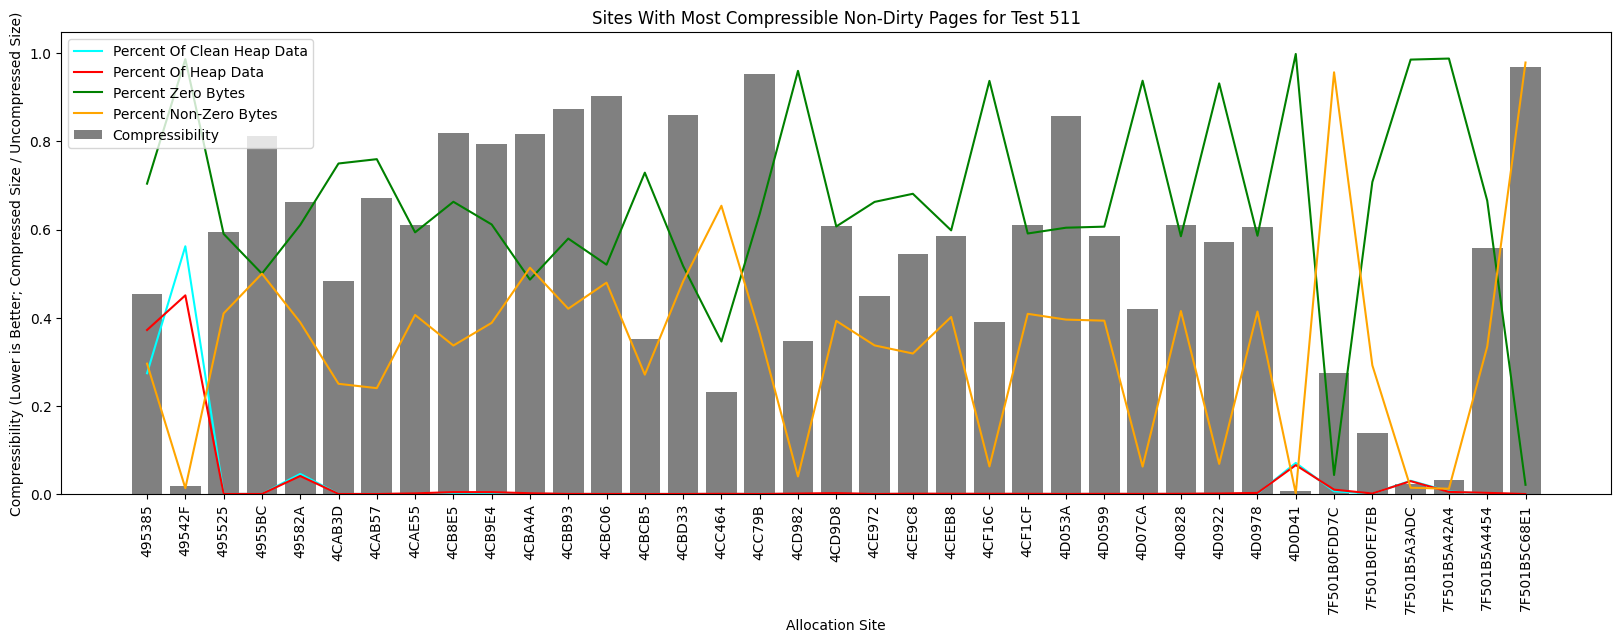

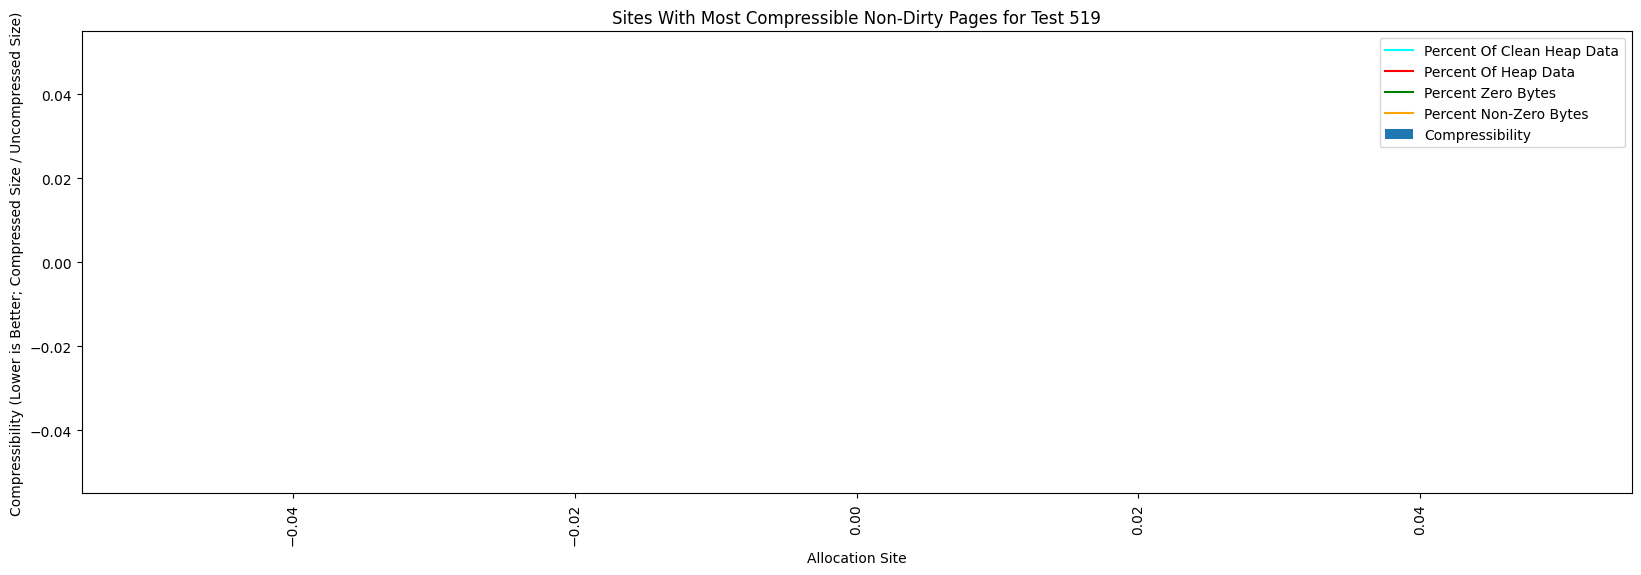

In [54]:

# Get the tests from the data
tests = data.keys()
for test in tests:
    # Get the data for the test
    test_data = data[test]
    # Get the allocation sites
    allocation_sites = test_data["Allocation Site"].unique()
    # Get the compressed and uncompressed sizes for the allocation sites
    compressed_sizes = test_data.groupby("Allocation Site")["Total Compressed Resident Size"]
    uncompressed_sizes = test_data.groupby("Allocation Site")["Total Uncompressed Resident Size"]
    
    # Get the compressibility of each allocation site
    compressibility = compressed_sizes.sum() / uncompressed_sizes.sum()

    # Now lets exclude the dirty pages from the compressibility calculation
    # Get the compressed and uncompressed sizes for the allocation sites
    compressed_resident_sizes = test_data.groupby("Allocation Site")["Total Compressed Resident Size"]
    uncompressed_resident_sizes = test_data.groupby("Allocation Site")["Total Uncompressed Resident Size"]

    compressed_clean_sizes = test_data.groupby("Allocation Site")["Total Compressed Clean Size"]
    uncompressed_clean_sizes = test_data.groupby("Allocation Site")["Total Uncompressed Clean Size"]

    compressed_dirty_sizes = test_data.groupby("Allocation Site")["Total Compressed Dirty Size"]
    uncompressed_dirty_sizes = test_data.groupby("Allocation Site")["Total Uncompressed Dirty Size"]


    # Show the compressibility of each category

    dirty_compressibility = compressed_dirty_sizes.sum() / uncompressed_dirty_sizes.sum()
    clean_compressibility = compressed_clean_sizes.sum() / uncompressed_clean_sizes.sum()
    resident_compressibility = compressed_resident_sizes.sum() / uncompressed_resident_sizes.sum()
    columns = 2
    last = left_positions = np.arange(len(resident_compressibility)) * columns
    last = resident_positions = last + bar_width
    last = dirty_positions = last + bar_width
    last = clean_positions = last + bar_width
    last = right_positions = last + bar_width
    center_positions = (left_positions + right_positions) / 2

    # Plot the allocation sites with the most compressible clean data
    plt.figure(figsize=(20,6))
    # Graph the size of each allocation site as a line over the bars
    allocation_site_resident_size = (test_data.groupby("Allocation Site")["Total Uncompressed Clean Size"].mean() + test_data.groupby("Allocation Site")["Total Uncompressed Dirty Size"].mean())
    allocation_site_clean_size = test_data.groupby("Allocation Site")["Total Uncompressed Clean Size"].mean()
    zero_byte_count = test_data.groupby("Allocation Site")["Zero Byte Count"].mean()
    non_zero_byte_count = test_data.groupby("Allocation Site")["Non-Zero Byte Count"].mean()
    # Only get the allocation sites that are in the compressible range
    allocation_site_resident_size = allocation_site_resident_size[clean_compressibility < 1]
    allocation_site_clean_size = allocation_site_clean_size[clean_compressibility < 1]
    zero_byte_count = zero_byte_count[clean_compressibility < 1]
    non_zero_byte_count = non_zero_byte_count[clean_compressibility < 1]
    total_byte_count = zero_byte_count + non_zero_byte_count
    # Rescale to a percentage
    zero_byte_count = zero_byte_count / total_byte_count
    non_zero_byte_count = non_zero_byte_count / total_byte_count

    allocation_site_clean_size = allocation_site_clean_size / allocation_site_clean_size.sum()
    allocation_site_resident_size = allocation_site_resident_size / allocation_site_resident_size.sum()
    

    # Draw over the bars, so the bars are still visible
    plt.plot(allocation_site_clean_size.index, allocation_site_clean_size.values, color="cyan", label="Percent Of Clean Heap Data")
    plt.plot(allocation_site_resident_size.index, allocation_site_resident_size.values, color="red", label="Percent Of Heap Data")
    plt.plot(zero_byte_count.index, zero_byte_count.values, color="green", label="Percent Zero Bytes")
    plt.plot(non_zero_byte_count.index, non_zero_byte_count.values, color="orange", label="Percent Non-Zero Bytes")
    plt.bar(clean_compressibility[clean_compressibility < 1].index, clean_compressibility[clean_compressibility < 1].values, color="grey", label="Compressibility")
    plt.title("Sites With Most Compressible Non-Dirty Pages for Test " + str(test))
    plt.xlabel("Allocation Site")
    plt.ylabel("Compressibility (Lower is Better; Compressed Size / Uncompressed Size)")
    plt.xticks(rotation=90)

    plt.legend()
    plt.show()


## 3.5 Identify Compressible, But "Hot" Data (Not Desirable)

Find what portion of compressible data sites are hot vs. cold.

Median dirty pages:  1.0


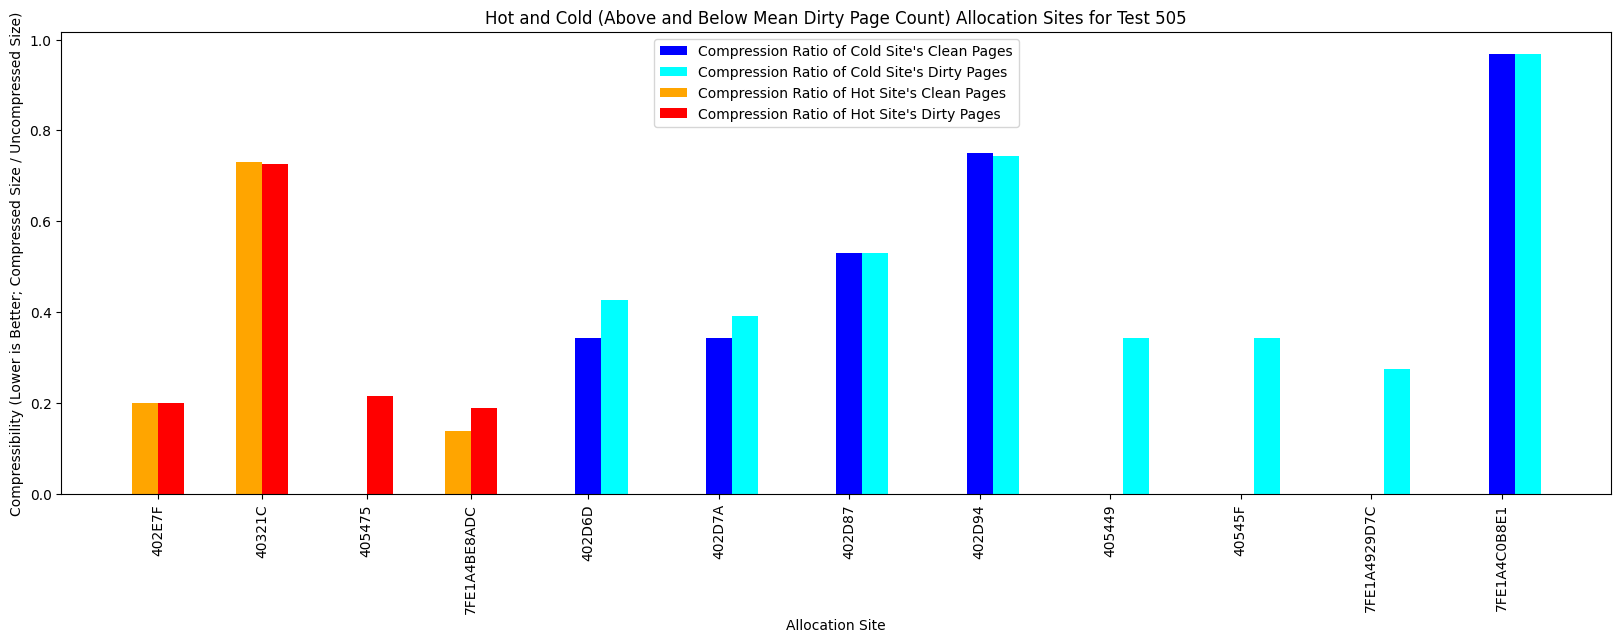

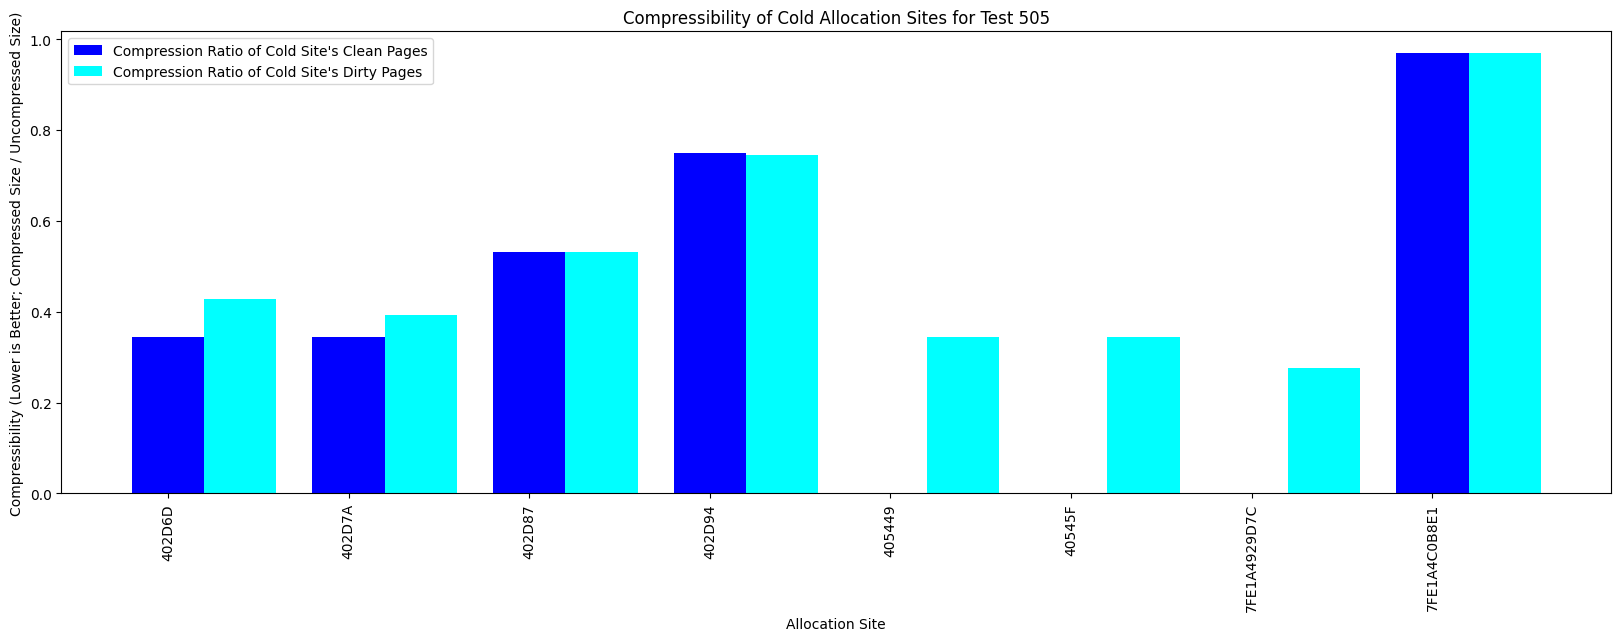

Median dirty pages:  10.916666666666666


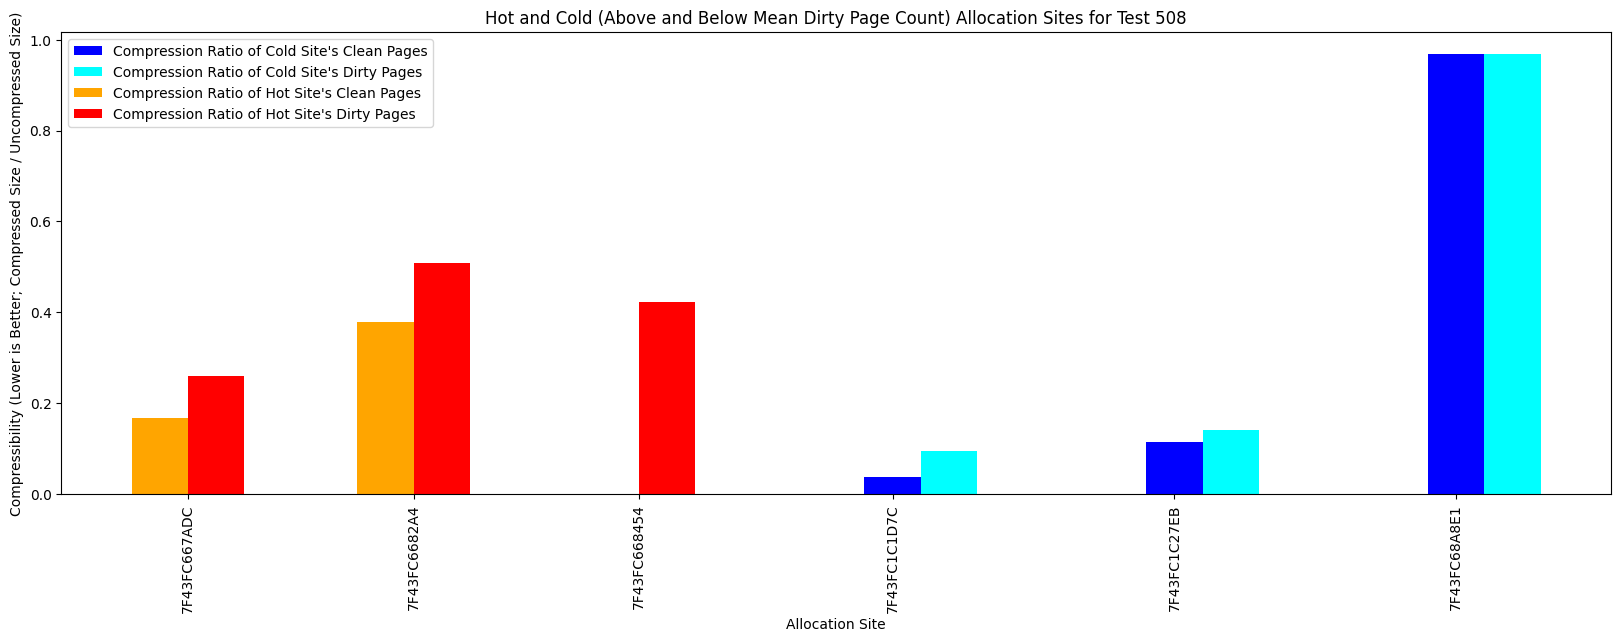

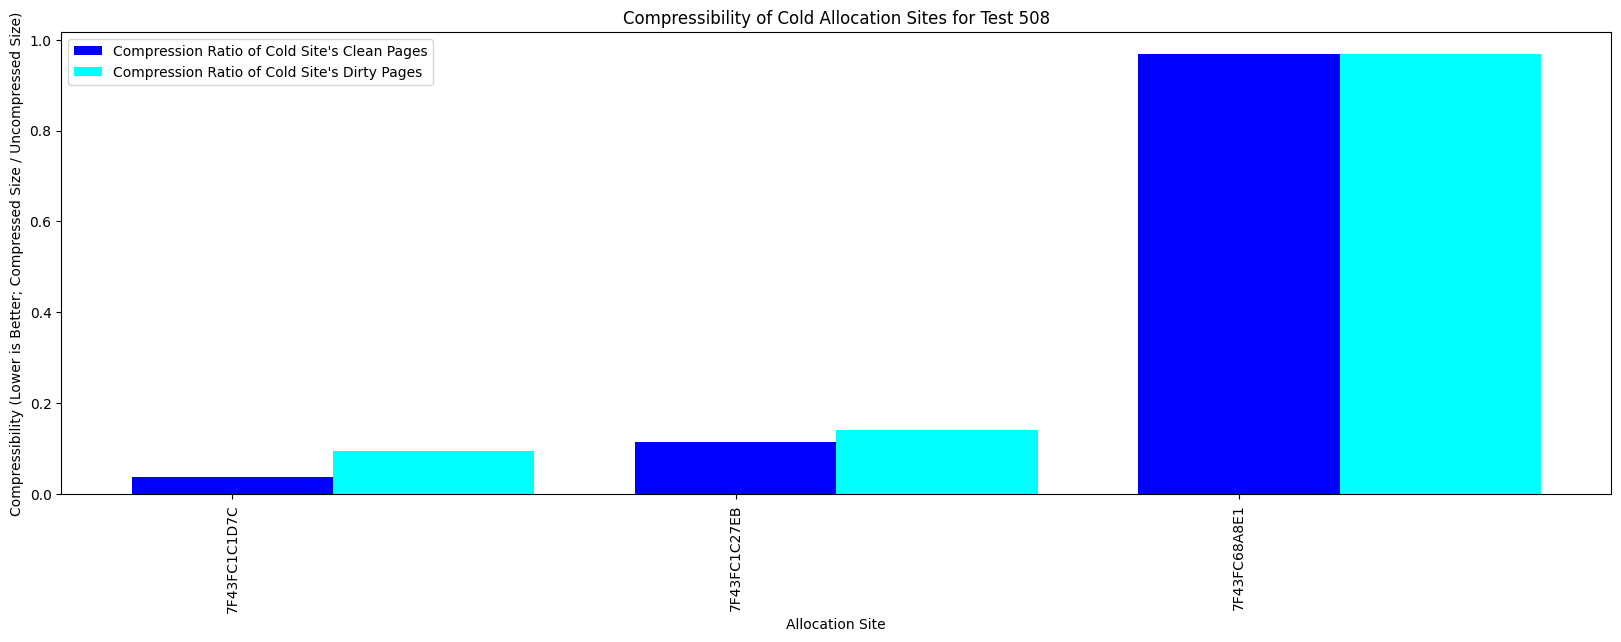

Median dirty pages:  3.7211538461538463


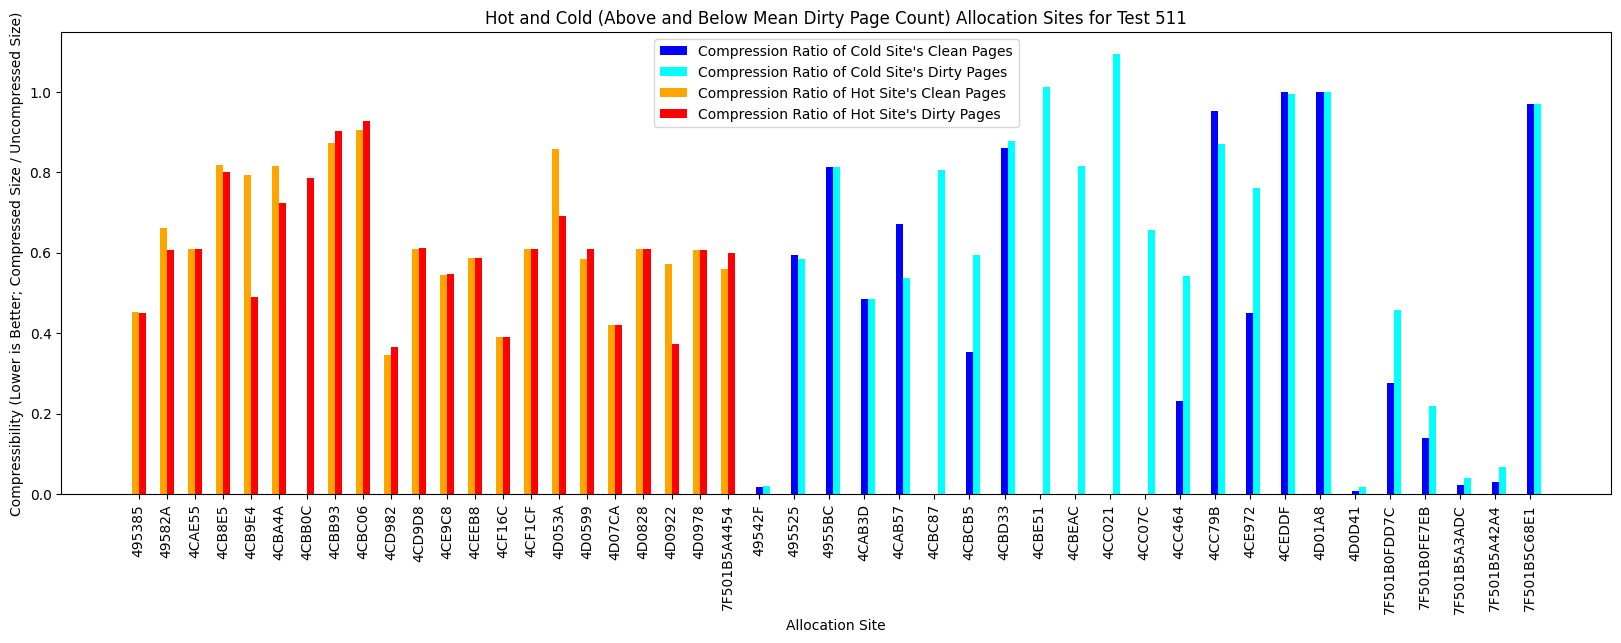

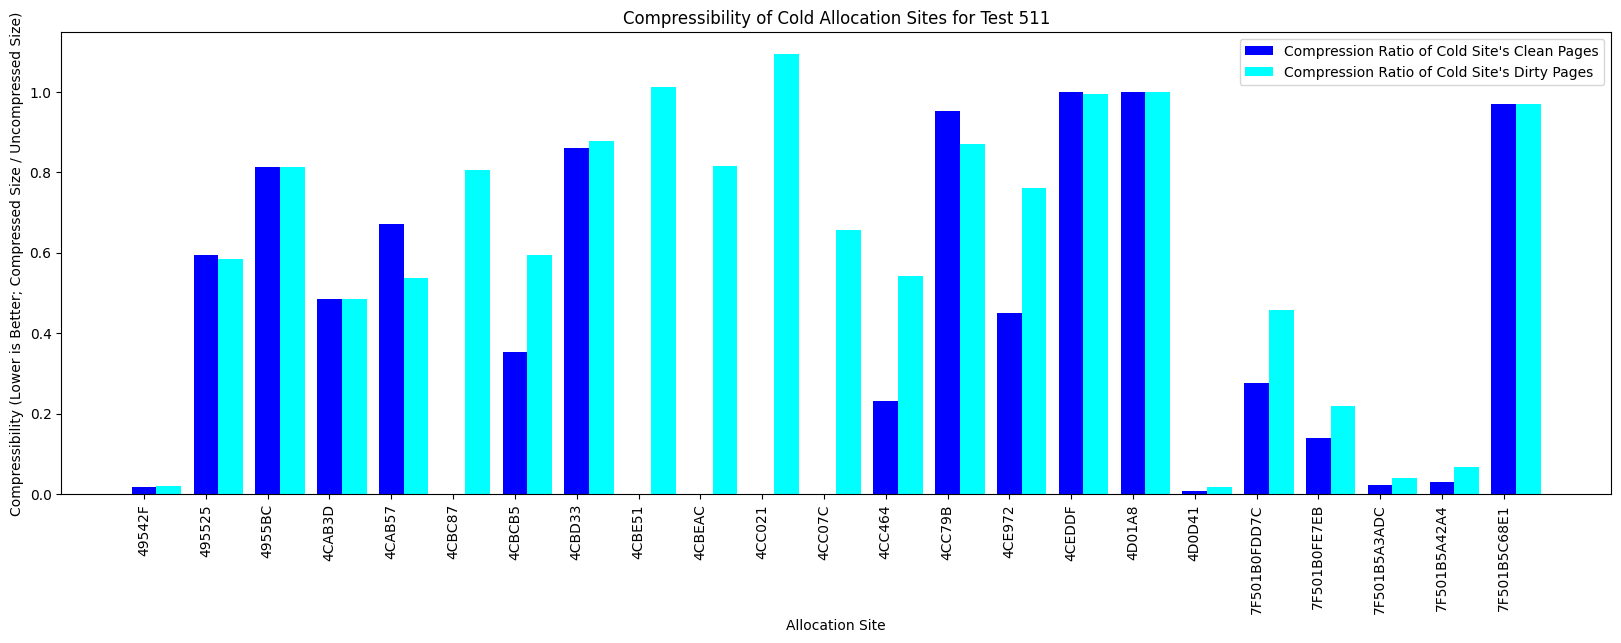

Median dirty pages:  1.0


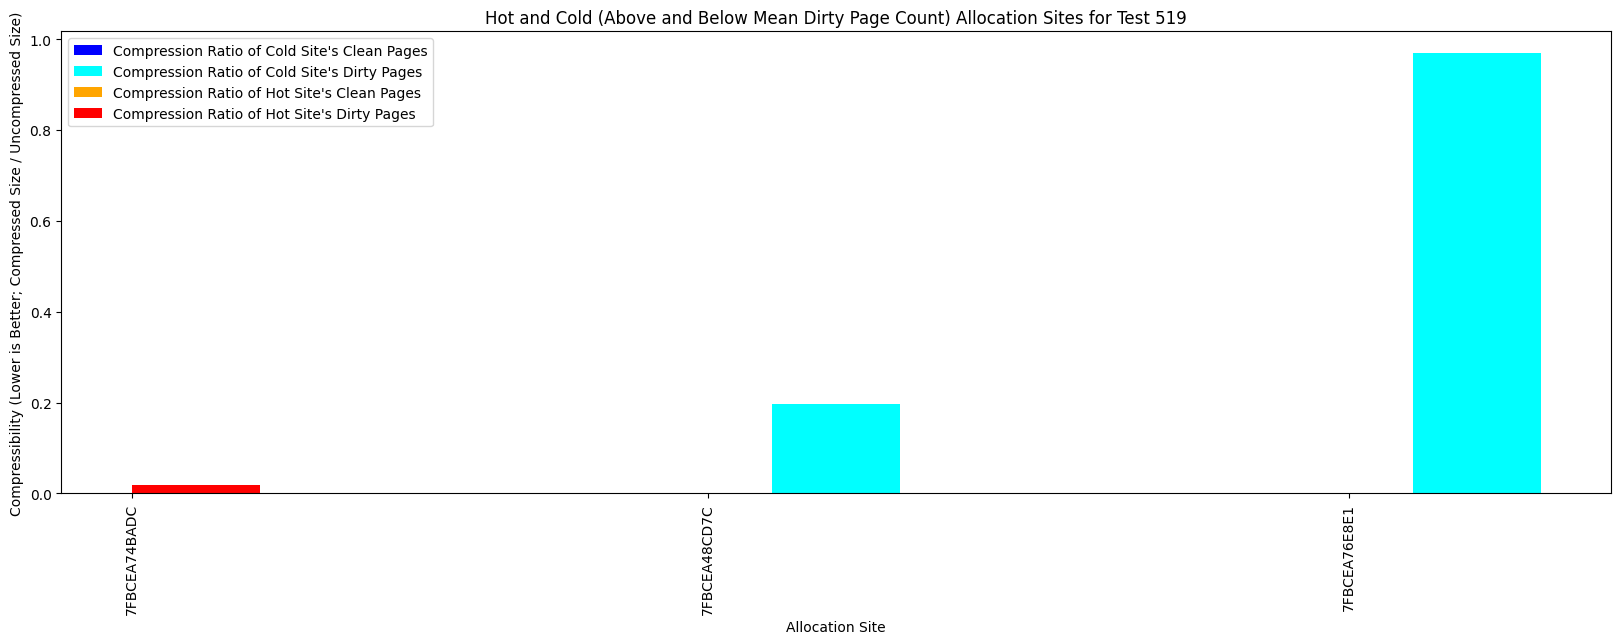

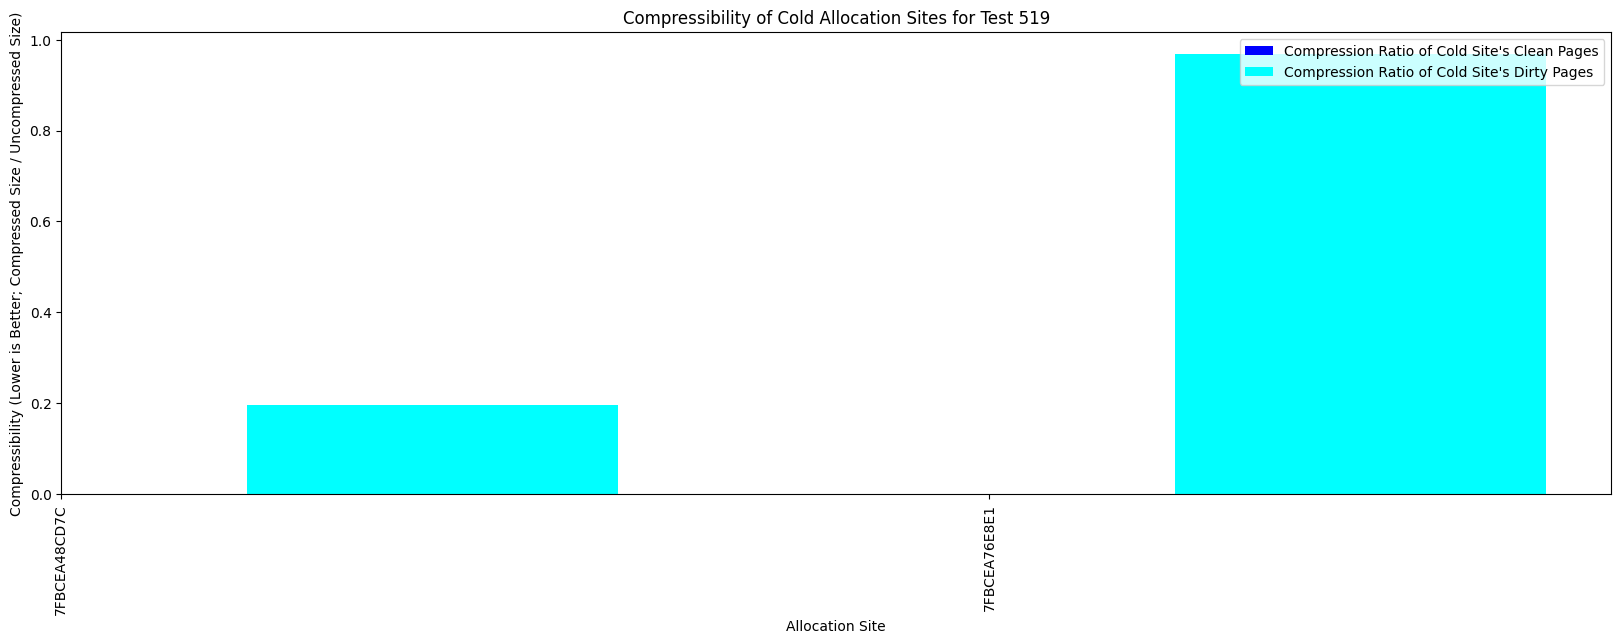

In [55]:

bar_width = 0.4
# Get the tests from the data
tests = data.keys()
for test in tests:
    # Get the data for the test
    test_data = data[test]
    # Get the allocation sites
    allocation_sites = test_data["Allocation Site"].unique()
    # Get the compressed and uncompressed sizes for the allocation sites
    compressed_sizes = test_data.groupby("Allocation Site")["Total Compressed Resident Size"]
    uncompressed_sizes = test_data.groupby("Allocation Site")["Total Uncompressed Resident Size"]

    dirty_pages = test_data.groupby("Allocation Site")["Dirty Pages"]
    
    # Get the compressibility of each allocation site
    compressibility = compressed_sizes.sum() / uncompressed_sizes.sum()

    # Now lets exclude the dirty pages from the compressibility calculation
    # Get the compressed and uncompressed sizes for the allocation sites
    compressed_resident_sizes = test_data.groupby("Allocation Site")["Total Compressed Resident Size"]
    uncompressed_resident_sizes = test_data.groupby("Allocation Site")["Total Uncompressed Resident Size"]

    compressed_clean_sizes = test_data.groupby("Allocation Site")["Total Compressed Clean Size"]
    uncompressed_clean_sizes = test_data.groupby("Allocation Site")["Total Uncompressed Clean Size"]

    compressed_dirty_sizes = test_data.groupby("Allocation Site")["Total Compressed Dirty Size"]
    uncompressed_dirty_sizes = test_data.groupby("Allocation Site")["Total Uncompressed Dirty Size"]

    dirty_compressibility = compressed_dirty_sizes.sum() / uncompressed_dirty_sizes.sum()
    clean_compressibility = compressed_clean_sizes.sum() / uncompressed_clean_sizes.sum()
    resident_compressibility = compressed_resident_sizes.sum() / uncompressed_resident_sizes.sum()

    # Find the "Hot" allocation sites
    # These are the allocation sites that have the most dirty pages

    # Get the dirty pages for each allocation site
    dirty_pages = test_data.groupby("Allocation Site")["Dirty Pages"]
    # Get the median dirty pages
    average_dirty_pages_per_site = dirty_pages.mean()
    print("Median dirty pages: ", average_dirty_pages_per_site.median())
    # Get the allocation sites with higher than the median dirty pages
    hot_allocation_sites = average_dirty_pages_per_site[average_dirty_pages_per_site > average_dirty_pages_per_site.median()].index
    cold_allocation_sites = average_dirty_pages_per_site[average_dirty_pages_per_site <= average_dirty_pages_per_site.median()].index

    # Get the compressibility of the hot and cold allocation sites
    hot_allocation_sites_clean_compressibility = clean_compressibility[hot_allocation_sites]
    hot_allocation_sites_dirty_compressibility = dirty_compressibility[hot_allocation_sites]
    cold_allocation_sites_clean_compressibility = clean_compressibility[cold_allocation_sites]
    cold_allocation_sites_dirty_compressibility = dirty_compressibility[cold_allocation_sites]


    # Plot the hot allocation sites
    plt.figure(figsize=(20,6))
    plt.title("Hot and Cold (Above and Below Mean Dirty Page Count) Allocation Sites for Test " + str(test))
    plt.xlabel("Allocation Site")
    plt.ylabel("Compressibility (Lower is Better; Compressed Size / Uncompressed Size)")
    plt.xticks(rotation=90)

    columns = 2
    hot_clean_positions = np.arange(len(hot_allocation_sites_clean_compressibility)) * columns * bar_width * 2
    hot_dirty_positions = hot_clean_positions + bar_width
    hot_positions = (hot_clean_positions + hot_dirty_positions) / 2
    # plt.xticks(hot_positions, hot_allocation_sites_clean_compressibility.index)

    cold_clean_positions = np.arange(len(cold_allocation_sites_clean_compressibility)) * columns + len(hot_allocation_sites_clean_compressibility) * columns * bar_width * 2 + bar_width
    cold_dirty_positions = cold_clean_positions + bar_width



    plt.bar(cold_clean_positions, cold_allocation_sites_clean_compressibility.values, width=bar_width, color="blue", label="Compression Ratio of Cold Site's Clean Pages")
    plt.bar(cold_dirty_positions, cold_allocation_sites_dirty_compressibility.values, width=bar_width, color="cyan", label="Compression Ratio of Cold Site's Dirty Pages")
    plt.bar(hot_clean_positions, hot_allocation_sites_clean_compressibility.values, width=bar_width, color="orange", label="Compression Ratio of Hot Site's Clean Pages")
    plt.bar(hot_dirty_positions, hot_allocation_sites_dirty_compressibility.values, width=bar_width, color="red", label="Compression Ratio of Hot Site's Dirty Pages")
    # Add the hot allocation sites to the x-axis
    plt.xticks(np.append(hot_positions, cold_clean_positions), np.append(hot_allocation_sites_clean_compressibility.index, cold_allocation_sites_clean_compressibility.index))
    plt.legend()
    plt.show()

    # Now show compressibility of cold allocation sites
    plt.figure(figsize=(20,6))
    plt.title("Compressibility of Cold Allocation Sites for Test " + str(test))
    plt.xlabel("Allocation Site")
    plt.ylabel("Compressibility (Lower is Better; Compressed Size / Uncompressed Size)")
    plt.xticks(rotation=90)
    cold_clean_positions = np.arange(len(cold_allocation_sites_clean_compressibility))
    cold_dirty_positions = cold_clean_positions + bar_width
    plt.bar(cold_clean_positions, cold_allocation_sites_clean_compressibility.values, width=bar_width, color="blue", label="Compression Ratio of Cold Site's Clean Pages")
    plt.bar(cold_dirty_positions, cold_allocation_sites_dirty_compressibility.values, width=bar_width, color="cyan", label="Compression Ratio of Cold Site's Dirty Pages")
    plt.xticks(cold_clean_positions, cold_allocation_sites_clean_compressibility.index)
    plt.legend()
    plt.show()

